<a href="https://colab.research.google.com/github/bumsikki/coding_test_prep/blob/main/hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision as tv
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import os

In [ ]:
train_batch_size=64
test_batch_size=1000

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, data="MNIST"):
        super(LeNet5,self).__init__()
        
        self.input_channel = 1
        self.conv1_padding = 2
        if data == "CIFAR-10":
          self.input_channel = 3
          self.conv1_padding = 0
  
        self.conv1 = nn.Sequential(
            nn.Conv2d(self.input_channel, 6, kernel_size=5, stride=1, padding = self.conv1_padding),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=x.view(-1,self.num_flat_features(x))
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

    def num_flat_features(self,x):
        #x is a 4D tensor
        x_size=x.size()[1:]
        num=1
        for n in x_size:
            num*=n
        return num

In [ ]:
def load_data(dataset_name="MNIST"):
    
    train_set = None
    test_set = None

    if dataset_name == "MNIST":
      transform=transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])
      
      train_set=tv.datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
      )
      
      test_set=tv.datasets.MNIST(
          root='./data',
          train=False,
          download=True,
          transform=transform
      )
    elif dataset_name == "Fashion-MNIST":

      transform=transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.28604,), (0.35302,))])
      
      train_set=tv.datasets.FashionMNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
      )
      
      test_set=tv.datasets.FashionMNIST(
          root='./data',
          train=False,
          download=True,
          transform=transform
      )
    elif dataset_name == "CIFAR-10":
     
      transform=transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])
      
      train_set=tv.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform
      )
      
      test_set=tv.datasets.CIFAR10(
          root='./data',
          train=False,
          download=True,
          transform=transform
      )
    
    train_loader=torch.utils.data.DataLoader(
      train_set,
      batch_size=train_batch_size,
      shuffle=True,
      num_workers=2)
    
    test_loader=torch.utils.data.DataLoader(
        test_set,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=2)
    

    print("data loaded successfully...")
    return train_loader,test_loader

def accuracy(model,x,neg=False):
    with torch.no_grad():
        correct=0
        total=0
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        for data in x:
            images,labels=data
            if neg:
              images=-images
            images,labels=images, labels
            outputs=model(images)
            _,predicted=torch.max(outputs.data,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
            
        return (100 * correct / total)

def train(train_loader, test_loader, model, criterion, optimizer,epoch):
    model.train()
    running_loss=0
    for i,data in enumerate(train_loader,0):
        inputs,labels=data
        inputs,labels=inputs, labels
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs=model(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss+=loss.item()
        if i%200==199:
            print("[epoch %d, iter %5d] loss: %.3f"%(epoch+1,i+1,running_loss/200))
            running_loss=0.0
    train_acc=accuracy(model,train_loader)
    test_acc=accuracy(model,test_loader)
    print("epoch %d: train_acc %.3f, test_acc %.3f"%(epoch+1,train_acc,test_acc))
    return train_acc,test_acc

def display(train_acc,test_acc):
    fig,ax=plt.subplots()
    ax.plot(range(1,len(train_acc)+1),train_acc,color='r',label='train_acc')
    ax.plot(range(1,len(test_acc)+1),test_acc,color='b',label='test_acc')
    ax.legend(loc='lower right')
    plt.show()

In [ ]:
def b(net,learning_rate, optimizer_name, gamma, dataset_name):
  train_loader,test_loader=load_data(dataset_name)
  # new model
  # net=LeNet5(data=dataset_name)

  # training
  max_epoch=10
  criterion=nn.CrossEntropyLoss()

  optimizer = None
  if optimizer_name == "SGD":
    momentum=0.9
    optimizer=optim.SGD(net.parameters(),lr=learning_rate,momentum=momentum)
  elif optimizer_name == "Adam":
    optimizer=optim.Adam(net.parameters(), lr= learning_rate)

  scheduler = None
  if gamma > 0:
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma = gamma)

  train_acc=[]
  test_acc=[]
  for epoch in range(max_epoch):
      if scheduler:
        scheduler.step()
      train_acc_t,test_acc_t=train(train_loader, test_loader, net, criterion, optimizer, epoch)
      train_acc.append(train_acc_t)
      test_acc.append(test_acc_t)

  display(train_acc,test_acc)
  return net

In [ ]:
learning_rates = [0.001, 0.001, 0.01]
gammas = [0, 0.90, 0]
optimizers = ["SGD", "SGD", "Adam"]
datasets = ["MNIST","Fashion-MNIST", "CIFAR-10"]

0.001 0 SGD
MNIST
iteration # 1


100%|██████████| 9912422/9912422 [00:00<00:00, 249989244.45it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 41641696.06it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 73582706.27it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4336564.71it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

data loaded successfully...


[epoch 1, iter   200] loss: 2.076
[epoch 1, iter   400] loss: 1.009
[epoch 1, iter   600] loss: 0.390
[epoch 1, iter   800] loss: 0.249
epoch 1: train_acc 94.818, test_acc 95.400
[epoch 2, iter   200] loss: 0.164
[epoch 2, iter   400] loss: 0.152
[epoch 2, iter   600] loss: 0.132
[epoch 2, iter   800] loss: 0.120
epoch 2: train_acc 96.722, test_acc 97.050
[epoch 3, iter   200] loss: 0.105
[epoch 3, iter   400] loss: 0.102
[epoch 3, iter   600] loss: 0.090
[epoch 3, iter   800] loss: 0.094
epoch 3: train_acc 97.435, test_acc 97.580
[epoch 4, iter   200] loss: 0.082
[epoch 4, iter   400] loss: 0.075
[epoch 4, iter   600] loss: 0.080
[epoch 4, iter   800] loss: 0.077
epoch 4: train_acc 97.943, test_acc 98.060
[epoch 5, iter   200] loss: 0.073
[epoch 5, iter   400] loss: 0.072
[epoch 5, iter   600] loss: 0.066
[epoch 5, iter   800] loss: 0.063
epoch 5: train_acc 98.150, test_acc 98.370
[epoch 6, iter   200] loss: 0.060
[epoch 6, iter   400] loss: 0.057
[epoch 6, iter   600] loss: 0.063
[ep

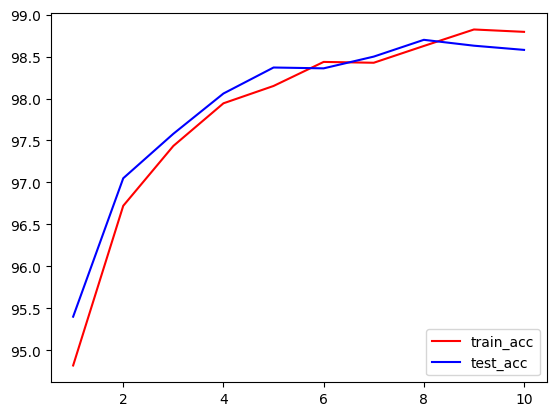


0.001 0 SGD
MNIST
iteration # 2
data loaded successfully...
[epoch 1, iter   200] loss: 2.108
[epoch 1, iter   400] loss: 1.007
[epoch 1, iter   600] loss: 0.377
[epoch 1, iter   800] loss: 0.243
epoch 1: train_acc 95.118, test_acc 95.330
[epoch 2, iter   200] loss: 0.165
[epoch 2, iter   400] loss: 0.153
[epoch 2, iter   600] loss: 0.126
[epoch 2, iter   800] loss: 0.118
epoch 2: train_acc 96.993, test_acc 96.820
[epoch 3, iter   200] loss: 0.101
[epoch 3, iter   400] loss: 0.097
[epoch 3, iter   600] loss: 0.096
[epoch 3, iter   800] loss: 0.087
epoch 3: train_acc 97.678, test_acc 97.390
[epoch 4, iter   200] loss: 0.078
[epoch 4, iter   400] loss: 0.079
[epoch 4, iter   600] loss: 0.076
[epoch 4, iter   800] loss: 0.069
epoch 4: train_acc 98.055, test_acc 97.920
[epoch 5, iter   200] loss: 0.062
[epoch 5, iter   400] loss: 0.066
[epoch 5, iter   600] loss: 0.064
[epoch 5, iter   800] loss: 0.068
epoch 5: train_acc 98.253, test_acc 97.930
[epoch 6, iter   200] loss: 0.059
[epoch 6, 

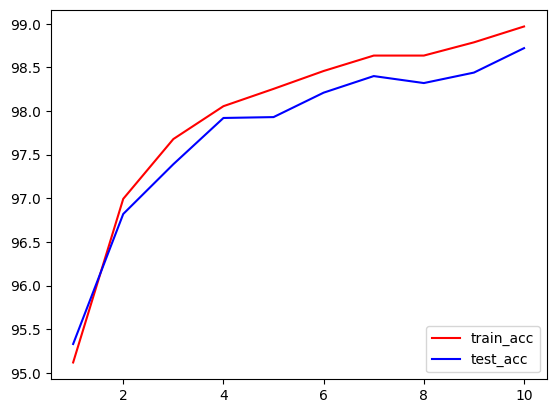


0.001 0 SGD
MNIST
iteration # 3
data loaded successfully...
[epoch 1, iter   200] loss: 2.018
[epoch 1, iter   400] loss: 0.842
[epoch 1, iter   600] loss: 0.318
[epoch 1, iter   800] loss: 0.232
epoch 1: train_acc 95.347, test_acc 95.970
[epoch 2, iter   200] loss: 0.161
[epoch 2, iter   400] loss: 0.144
[epoch 2, iter   600] loss: 0.131
[epoch 2, iter   800] loss: 0.115
epoch 2: train_acc 97.082, test_acc 97.320
[epoch 3, iter   200] loss: 0.104
[epoch 3, iter   400] loss: 0.094
[epoch 3, iter   600] loss: 0.093
[epoch 3, iter   800] loss: 0.091
epoch 3: train_acc 97.542, test_acc 97.930
[epoch 4, iter   200] loss: 0.076
[epoch 4, iter   400] loss: 0.078
[epoch 4, iter   600] loss: 0.082
[epoch 4, iter   800] loss: 0.075
epoch 4: train_acc 97.957, test_acc 98.160
[epoch 5, iter   200] loss: 0.069
[epoch 5, iter   400] loss: 0.068
[epoch 5, iter   600] loss: 0.062
[epoch 5, iter   800] loss: 0.064
epoch 5: train_acc 98.187, test_acc 98.210
[epoch 6, iter   200] loss: 0.056
[epoch 6, 

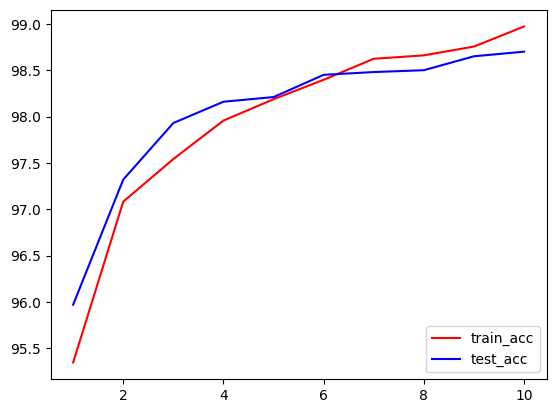


0.001 0 SGD
MNIST
iteration # 4
data loaded successfully...
[epoch 1, iter   200] loss: 2.023
[epoch 1, iter   400] loss: 0.861
[epoch 1, iter   600] loss: 0.363
[epoch 1, iter   800] loss: 0.258
epoch 1: train_acc 94.873, test_acc 95.450
[epoch 2, iter   200] loss: 0.177
[epoch 2, iter   400] loss: 0.148
[epoch 2, iter   600] loss: 0.139
[epoch 2, iter   800] loss: 0.118
epoch 2: train_acc 96.853, test_acc 97.040
[epoch 3, iter   200] loss: 0.109
[epoch 3, iter   400] loss: 0.096
[epoch 3, iter   600] loss: 0.097
[epoch 3, iter   800] loss: 0.088
epoch 3: train_acc 97.528, test_acc 97.760
[epoch 4, iter   200] loss: 0.080
[epoch 4, iter   400] loss: 0.080
[epoch 4, iter   600] loss: 0.078
[epoch 4, iter   800] loss: 0.070
epoch 4: train_acc 98.085, test_acc 98.210
[epoch 5, iter   200] loss: 0.068
[epoch 5, iter   400] loss: 0.064
[epoch 5, iter   600] loss: 0.063
[epoch 5, iter   800] loss: 0.066
epoch 5: train_acc 98.362, test_acc 98.310
[epoch 6, iter   200] loss: 0.054
[epoch 6, 

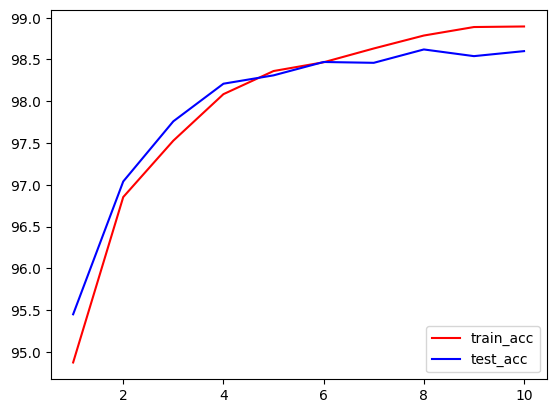


0.001 0 SGD
MNIST
iteration # 5
data loaded successfully...
[epoch 1, iter   200] loss: 2.055
[epoch 1, iter   400] loss: 0.939
[epoch 1, iter   600] loss: 0.358
[epoch 1, iter   800] loss: 0.245
epoch 1: train_acc 94.753, test_acc 95.200
[epoch 2, iter   200] loss: 0.172
[epoch 2, iter   400] loss: 0.157
[epoch 2, iter   600] loss: 0.138
[epoch 2, iter   800] loss: 0.128
epoch 2: train_acc 96.675, test_acc 96.980
[epoch 3, iter   200] loss: 0.106
[epoch 3, iter   400] loss: 0.108
[epoch 3, iter   600] loss: 0.098
[epoch 3, iter   800] loss: 0.089
epoch 3: train_acc 97.505, test_acc 97.670
[epoch 4, iter   200] loss: 0.085
[epoch 4, iter   400] loss: 0.079
[epoch 4, iter   600] loss: 0.076
[epoch 4, iter   800] loss: 0.079
epoch 4: train_acc 97.818, test_acc 98.140
[epoch 5, iter   200] loss: 0.073
[epoch 5, iter   400] loss: 0.066
[epoch 5, iter   600] loss: 0.069
[epoch 5, iter   800] loss: 0.066
epoch 5: train_acc 98.243, test_acc 98.320
[epoch 6, iter   200] loss: 0.055
[epoch 6, 

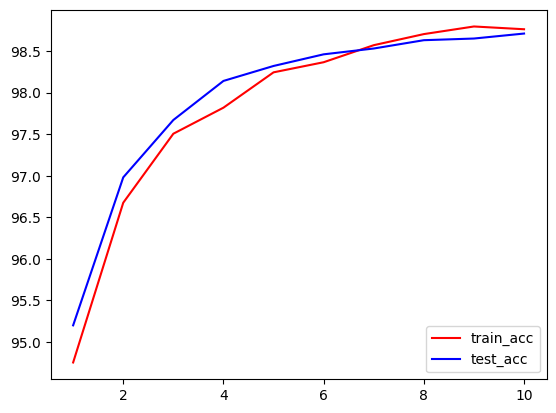


0.001 0.9 SGD
MNIST
iteration # 1
data loaded successfully...


/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[epoch 1, iter   200] loss: 2.074
[epoch 1, iter   400] loss: 1.071
[epoch 1, iter   600] loss: 0.462
[epoch 1, iter   800] loss: 0.283
epoch 1: train_acc 94.388, test_acc 94.920
[epoch 2, iter   200] loss: 0.195
[epoch 2, iter   400] loss: 0.159
[epoch 2, iter   600] loss: 0.148
[epoch 2, iter   800] loss: 0.144
epoch 2: train_acc 96.288, test_acc 96.600
[epoch 3, iter   200] loss: 0.124
[epoch 3, iter   400] loss: 0.121
[epoch 3, iter   600] loss: 0.113
[epoch 3, iter   800] loss: 0.098
epoch 3: train_acc 97.120, test_acc 97.370
[epoch 4, iter   200] loss: 0.100
[epoch 4, iter   400] loss: 0.094
[epoch 4, iter   600] loss: 0.091
[epoch 4, iter   800] loss: 0.087
epoch 4: train_acc 97.562, test_acc 97.740
[epoch 5, iter   200] loss: 0.082
[epoch 5, iter   400] loss: 0.082
[epoch 5, iter   600] loss: 0.079
[epoch 5, iter   800] loss: 0.081
epoch 5: train_acc 97.767, test_acc 97.920
[epoch 6, iter   200] loss: 0.079
[epoch 6, iter   400] loss: 0.072
[epoch 6, iter   600] loss: 0.071
[ep

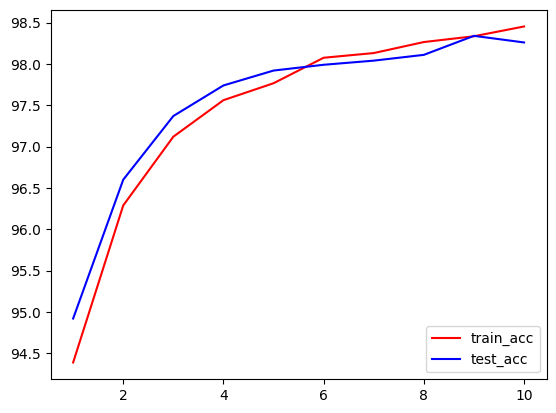


0.001 0.9 SGD
MNIST
iteration # 2
data loaded successfully...
[epoch 1, iter   200] loss: 2.121
[epoch 1, iter   400] loss: 1.157
[epoch 1, iter   600] loss: 0.446
[epoch 1, iter   800] loss: 0.279
epoch 1: train_acc 94.342, test_acc 94.800
[epoch 2, iter   200] loss: 0.186
[epoch 2, iter   400] loss: 0.178
[epoch 2, iter   600] loss: 0.149
[epoch 2, iter   800] loss: 0.148
epoch 2: train_acc 96.418, test_acc 96.640
[epoch 3, iter   200] loss: 0.123
[epoch 3, iter   400] loss: 0.117
[epoch 3, iter   600] loss: 0.109
[epoch 3, iter   800] loss: 0.107
epoch 3: train_acc 97.103, test_acc 97.270
[epoch 4, iter   200] loss: 0.097
[epoch 4, iter   400] loss: 0.092
[epoch 4, iter   600] loss: 0.086
[epoch 4, iter   800] loss: 0.091
epoch 4: train_acc 97.590, test_acc 97.710
[epoch 5, iter   200] loss: 0.078
[epoch 5, iter   400] loss: 0.088
[epoch 5, iter   600] loss: 0.080
[epoch 5, iter   800] loss: 0.072
epoch 5: train_acc 97.820, test_acc 97.860
[epoch 6, iter   200] loss: 0.074
[epoch 6

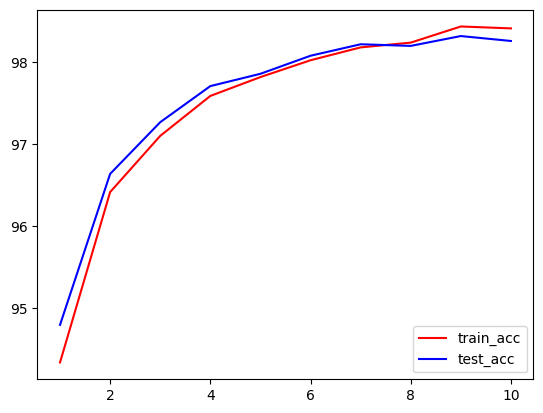


0.001 0.9 SGD
MNIST
iteration # 3
data loaded successfully...
[epoch 1, iter   200] loss: 2.107
[epoch 1, iter   400] loss: 1.147
[epoch 1, iter   600] loss: 0.445
[epoch 1, iter   800] loss: 0.286
epoch 1: train_acc 94.370, test_acc 94.680
[epoch 2, iter   200] loss: 0.188
[epoch 2, iter   400] loss: 0.173
[epoch 2, iter   600] loss: 0.146
[epoch 2, iter   800] loss: 0.142
epoch 2: train_acc 96.407, test_acc 96.800
[epoch 3, iter   200] loss: 0.124
[epoch 3, iter   400] loss: 0.115
[epoch 3, iter   600] loss: 0.110
[epoch 3, iter   800] loss: 0.107
epoch 3: train_acc 97.152, test_acc 97.480
[epoch 4, iter   200] loss: 0.092
[epoch 4, iter   400] loss: 0.103
[epoch 4, iter   600] loss: 0.090
[epoch 4, iter   800] loss: 0.088
epoch 4: train_acc 97.593, test_acc 97.840
[epoch 5, iter   200] loss: 0.081
[epoch 5, iter   400] loss: 0.082
[epoch 5, iter   600] loss: 0.077
[epoch 5, iter   800] loss: 0.082
epoch 5: train_acc 97.802, test_acc 98.050
[epoch 6, iter   200] loss: 0.072
[epoch 6

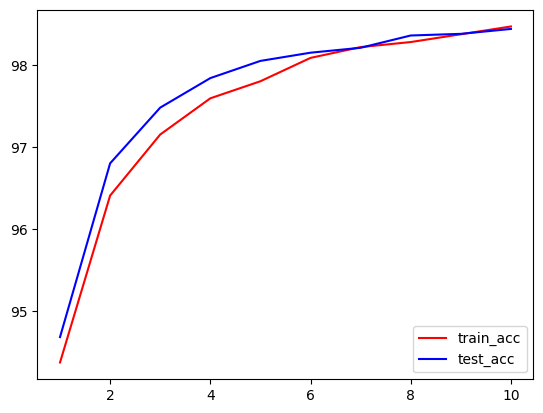


0.001 0.9 SGD
MNIST
iteration # 4
data loaded successfully...
[epoch 1, iter   200] loss: 2.104
[epoch 1, iter   400] loss: 1.080
[epoch 1, iter   600] loss: 0.441
[epoch 1, iter   800] loss: 0.275
epoch 1: train_acc 94.690, test_acc 95.160
[epoch 2, iter   200] loss: 0.173
[epoch 2, iter   400] loss: 0.165
[epoch 2, iter   600] loss: 0.139
[epoch 2, iter   800] loss: 0.139
epoch 2: train_acc 96.675, test_acc 97.000
[epoch 3, iter   200] loss: 0.113
[epoch 3, iter   400] loss: 0.111
[epoch 3, iter   600] loss: 0.100
[epoch 3, iter   800] loss: 0.096
epoch 3: train_acc 97.392, test_acc 97.690
[epoch 4, iter   200] loss: 0.088
[epoch 4, iter   400] loss: 0.088
[epoch 4, iter   600] loss: 0.087
[epoch 4, iter   800] loss: 0.084
epoch 4: train_acc 97.738, test_acc 97.980
[epoch 5, iter   200] loss: 0.080
[epoch 5, iter   400] loss: 0.078
[epoch 5, iter   600] loss: 0.075
[epoch 5, iter   800] loss: 0.071
epoch 5: train_acc 97.977, test_acc 98.000
[epoch 6, iter   200] loss: 0.070
[epoch 6

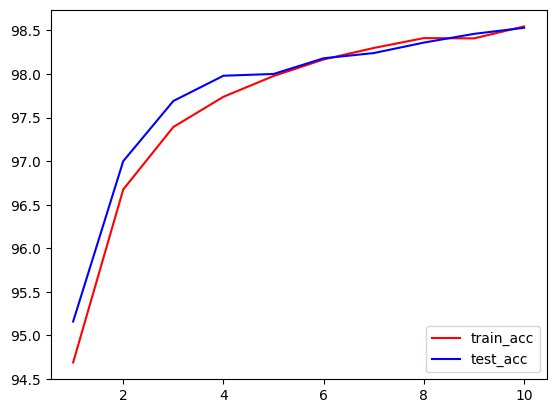


0.001 0.9 SGD
MNIST
iteration # 5
data loaded successfully...
[epoch 1, iter   200] loss: 2.078
[epoch 1, iter   400] loss: 1.071
[epoch 1, iter   600] loss: 0.453
[epoch 1, iter   800] loss: 0.270
epoch 1: train_acc 94.673, test_acc 95.100
[epoch 2, iter   200] loss: 0.189
[epoch 2, iter   400] loss: 0.158
[epoch 2, iter   600] loss: 0.146
[epoch 2, iter   800] loss: 0.128
epoch 2: train_acc 96.450, test_acc 96.860
[epoch 3, iter   200] loss: 0.120
[epoch 3, iter   400] loss: 0.109
[epoch 3, iter   600] loss: 0.102
[epoch 3, iter   800] loss: 0.094
epoch 3: train_acc 97.390, test_acc 97.660
[epoch 4, iter   200] loss: 0.090
[epoch 4, iter   400] loss: 0.091
[epoch 4, iter   600] loss: 0.084
[epoch 4, iter   800] loss: 0.080
epoch 4: train_acc 97.705, test_acc 97.810
[epoch 5, iter   200] loss: 0.078
[epoch 5, iter   400] loss: 0.075
[epoch 5, iter   600] loss: 0.073
[epoch 5, iter   800] loss: 0.077
epoch 5: train_acc 98.002, test_acc 98.130
[epoch 6, iter   200] loss: 0.067
[epoch 6

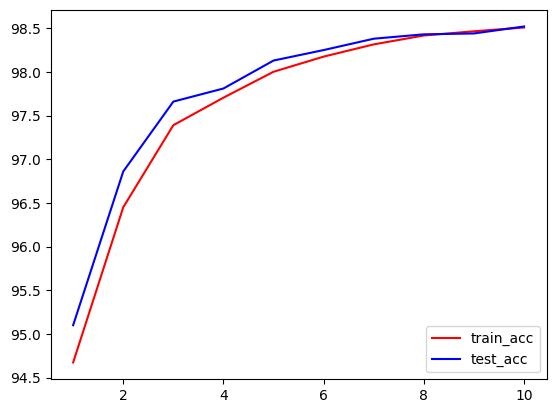


0.01 0 Adam
MNIST
iteration # 1
data loaded successfully...
[epoch 1, iter   200] loss: 0.298
[epoch 1, iter   400] loss: 0.125
[epoch 1, iter   600] loss: 0.089
[epoch 1, iter   800] loss: 0.080
epoch 1: train_acc 97.128, test_acc 97.310
[epoch 2, iter   200] loss: 0.078
[epoch 2, iter   400] loss: 0.067
[epoch 2, iter   600] loss: 0.059
[epoch 2, iter   800] loss: 0.069
epoch 2: train_acc 98.342, test_acc 98.310
[epoch 3, iter   200] loss: 0.060
[epoch 3, iter   400] loss: 0.055
[epoch 3, iter   600] loss: 0.058
[epoch 3, iter   800] loss: 0.053
epoch 3: train_acc 98.883, test_acc 98.590
[epoch 4, iter   200] loss: 0.052
[epoch 4, iter   400] loss: 0.047
[epoch 4, iter   600] loss: 0.046
[epoch 4, iter   800] loss: 0.051
epoch 4: train_acc 98.970, test_acc 98.580
[epoch 5, iter   200] loss: 0.038
[epoch 5, iter   400] loss: 0.051
[epoch 5, iter   600] loss: 0.045
[epoch 5, iter   800] loss: 0.049
epoch 5: train_acc 98.765, test_acc 98.510
[epoch 6, iter   200] loss: 0.038
[epoch 6, 

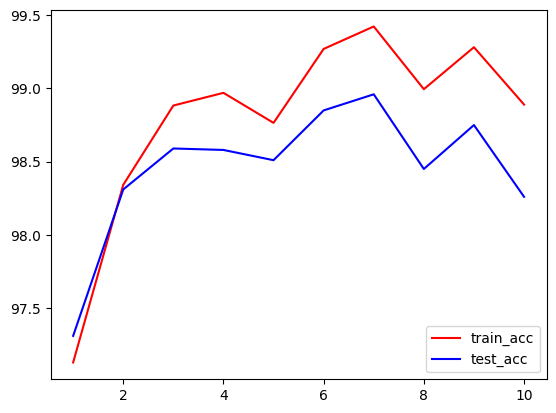


0.01 0 Adam
MNIST
iteration # 2
data loaded successfully...
[epoch 1, iter   200] loss: 0.336
[epoch 1, iter   400] loss: 0.116
[epoch 1, iter   600] loss: 0.088
[epoch 1, iter   800] loss: 0.089
epoch 1: train_acc 98.297, test_acc 98.360
[epoch 2, iter   200] loss: 0.067
[epoch 2, iter   400] loss: 0.053
[epoch 2, iter   600] loss: 0.059
[epoch 2, iter   800] loss: 0.062
epoch 2: train_acc 98.027, test_acc 97.850
[epoch 3, iter   200] loss: 0.052
[epoch 3, iter   400] loss: 0.050
[epoch 3, iter   600] loss: 0.055
[epoch 3, iter   800] loss: 0.055
epoch 3: train_acc 98.135, test_acc 97.910
[epoch 4, iter   200] loss: 0.058
[epoch 4, iter   400] loss: 0.052
[epoch 4, iter   600] loss: 0.046
[epoch 4, iter   800] loss: 0.051
epoch 4: train_acc 98.790, test_acc 98.240
[epoch 5, iter   200] loss: 0.045
[epoch 5, iter   400] loss: 0.040
[epoch 5, iter   600] loss: 0.046
[epoch 5, iter   800] loss: 0.048
epoch 5: train_acc 99.085, test_acc 98.590
[epoch 6, iter   200] loss: 0.041
[epoch 6, 

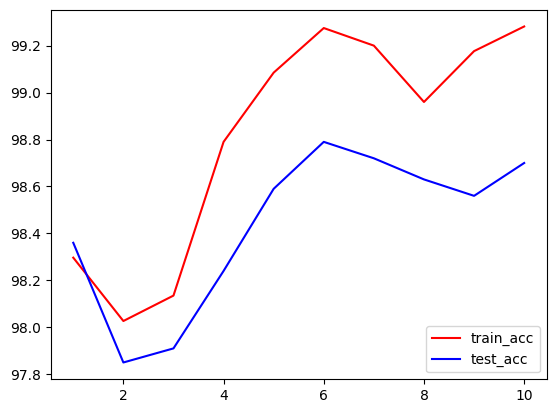


0.01 0 Adam
MNIST
iteration # 3
data loaded successfully...
[epoch 1, iter   200] loss: 0.294
[epoch 1, iter   400] loss: 0.113
[epoch 1, iter   600] loss: 0.098
[epoch 1, iter   800] loss: 0.080
epoch 1: train_acc 97.890, test_acc 97.770
[epoch 2, iter   200] loss: 0.060
[epoch 2, iter   400] loss: 0.062
[epoch 2, iter   600] loss: 0.068
[epoch 2, iter   800] loss: 0.060
epoch 2: train_acc 98.390, test_acc 98.350
[epoch 3, iter   200] loss: 0.050
[epoch 3, iter   400] loss: 0.054
[epoch 3, iter   600] loss: 0.059
[epoch 3, iter   800] loss: 0.047
epoch 3: train_acc 98.962, test_acc 98.590
[epoch 4, iter   200] loss: 0.039
[epoch 4, iter   400] loss: 0.044
[epoch 4, iter   600] loss: 0.041
[epoch 4, iter   800] loss: 0.052
epoch 4: train_acc 99.142, test_acc 98.860
[epoch 5, iter   200] loss: 0.036
[epoch 5, iter   400] loss: 0.048
[epoch 5, iter   600] loss: 0.042
[epoch 5, iter   800] loss: 0.044
epoch 5: train_acc 98.970, test_acc 98.650
[epoch 6, iter   200] loss: 0.037
[epoch 6, 

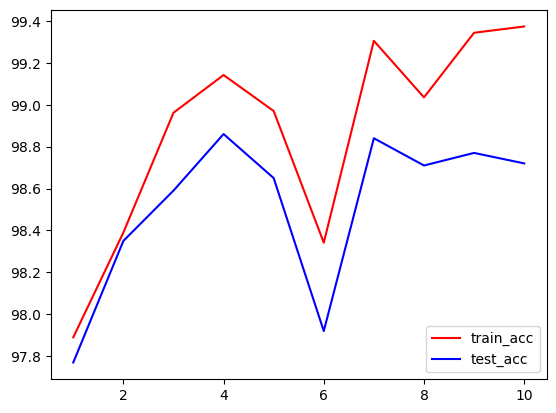


0.01 0 Adam
MNIST
iteration # 4
data loaded successfully...
[epoch 1, iter   200] loss: 0.358
[epoch 1, iter   400] loss: 0.129
[epoch 1, iter   600] loss: 0.089
[epoch 1, iter   800] loss: 0.085
epoch 1: train_acc 98.353, test_acc 98.270
[epoch 2, iter   200] loss: 0.070
[epoch 2, iter   400] loss: 0.071
[epoch 2, iter   600] loss: 0.060
[epoch 2, iter   800] loss: 0.060
epoch 2: train_acc 98.128, test_acc 97.950
[epoch 3, iter   200] loss: 0.053
[epoch 3, iter   400] loss: 0.053
[epoch 3, iter   600] loss: 0.051
[epoch 3, iter   800] loss: 0.059
epoch 3: train_acc 98.688, test_acc 98.360
[epoch 4, iter   200] loss: 0.044
[epoch 4, iter   400] loss: 0.047
[epoch 4, iter   600] loss: 0.048
[epoch 4, iter   800] loss: 0.049
epoch 4: train_acc 98.838, test_acc 98.560
[epoch 5, iter   200] loss: 0.043
[epoch 5, iter   400] loss: 0.046
[epoch 5, iter   600] loss: 0.048
[epoch 5, iter   800] loss: 0.043
epoch 5: train_acc 98.442, test_acc 98.130
[epoch 6, iter   200] loss: 0.034
[epoch 6, 

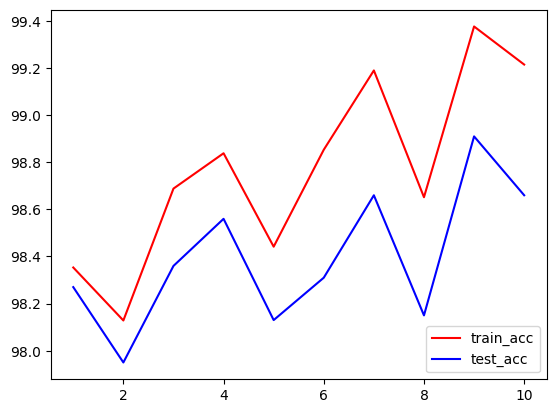


0.01 0 Adam
MNIST
iteration # 5
data loaded successfully...
[epoch 1, iter   200] loss: 0.337
[epoch 1, iter   400] loss: 0.117
[epoch 1, iter   600] loss: 0.098
[epoch 1, iter   800] loss: 0.082
epoch 1: train_acc 97.993, test_acc 98.030
[epoch 2, iter   200] loss: 0.064
[epoch 2, iter   400] loss: 0.070
[epoch 2, iter   600] loss: 0.057
[epoch 2, iter   800] loss: 0.065
epoch 2: train_acc 99.028, test_acc 98.730
[epoch 3, iter   200] loss: 0.045
[epoch 3, iter   400] loss: 0.057
[epoch 3, iter   600] loss: 0.063
[epoch 3, iter   800] loss: 0.049
epoch 3: train_acc 98.688, test_acc 98.450
[epoch 4, iter   200] loss: 0.040
[epoch 4, iter   400] loss: 0.046
[epoch 4, iter   600] loss: 0.043
[epoch 4, iter   800] loss: 0.047
epoch 4: train_acc 97.577, test_acc 97.220
[epoch 5, iter   200] loss: 0.043
[epoch 5, iter   400] loss: 0.048
[epoch 5, iter   600] loss: 0.041
[epoch 5, iter   800] loss: 0.047
epoch 5: train_acc 99.202, test_acc 98.740
[epoch 6, iter   200] loss: 0.039
[epoch 6, 

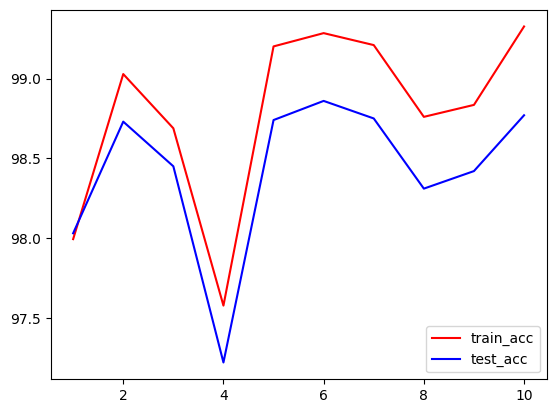


0.001 0 SGD
Fashion-MNIST
iteration # 1


100%|██████████| 26421880/26421880 [00:00<00:00, 112888038.29it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 4464455.36it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 61736771.86it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9416605.75it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

data loaded successfully...
[epoch 1, iter   200] loss: 1.868
[epoch 1, iter   400] loss: 0.908
[epoch 1, iter   600] loss: 0.665
[epoch 1, iter   800] loss: 0.575
epoch 1: train_acc 81.155, test_acc 80.610
[epoch 2, iter   200] loss: 0.503
[epoch 2, iter   400] loss: 0.464
[epoch 2, iter   600] loss: 0.443
[epoch 2, iter   800] loss: 0.429
epoch 2: train_acc 86.008, test_acc 85.170
[epoch 3, iter   200] loss: 0.412
[epoch 3, iter   400] loss: 0.379
[epoch 3, iter   600] loss: 0.377
[epoch 3, iter   800] loss: 0.363
epoch 3: train_acc 87.290, test_acc 86.420
[epoch 4, iter   200] loss: 0.364
[epoch 4, iter   400] loss: 0.352
[epoch 4, iter   600] loss: 0.338
[epoch 4, iter   800] loss: 0.332
epoch 4: train_acc 88.328, test_acc 87.270
[epoch 5, iter   200] loss: 0.334
[epoch 5, iter   400] loss: 0.326
[epoch 5, iter   600] loss: 0.321
[epoch 5, iter   800] loss: 0.317
epoch 5: train_acc 88.532, test

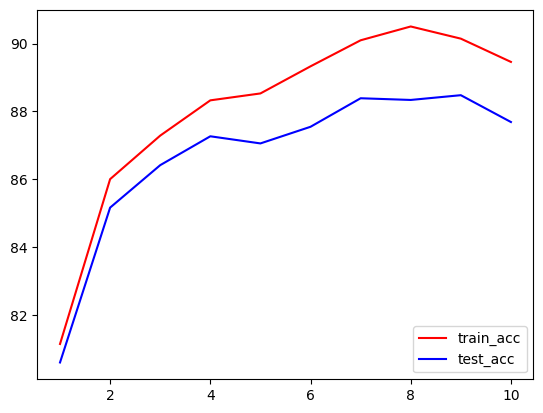


0.001 0 SGD
Fashion-MNIST
iteration # 2
data loaded successfully...
[epoch 1, iter   200] loss: 1.809
[epoch 1, iter   400] loss: 0.877
[epoch 1, iter   600] loss: 0.654
[epoch 1, iter   800] loss: 0.578
epoch 1: train_acc 80.817, test_acc 79.790
[epoch 2, iter   200] loss: 0.498
[epoch 2, iter   400] loss: 0.483
[epoch 2, iter   600] loss: 0.457
[epoch 2, iter   800] loss: 0.426
epoch 2: train_acc 85.607, test_acc 84.450
[epoch 3, iter   200] loss: 0.411
[epoch 3, iter   400] loss: 0.392
[epoch 3, iter   600] loss: 0.385
[epoch 3, iter   800] loss: 0.362
epoch 3: train_acc 87.142, test_acc 86.140
[epoch 4, iter   200] loss: 0.360
[epoch 4, iter   400] loss: 0.358
[epoch 4, iter   600] loss: 0.341
[epoch 4, iter   800] loss: 0.351
epoch 4: train_acc 88.227, test_acc 86.540
[epoch 5, iter   200] loss: 0.326
[epoch 5, iter   400] loss: 0.319
[epoch 5, iter   600] loss: 0.339
[epoch 5, iter   800] loss: 0.327
epoch 5: train_acc 89.120, test_acc 87.490
[epoch 6, iter   200] loss: 0.309
[e

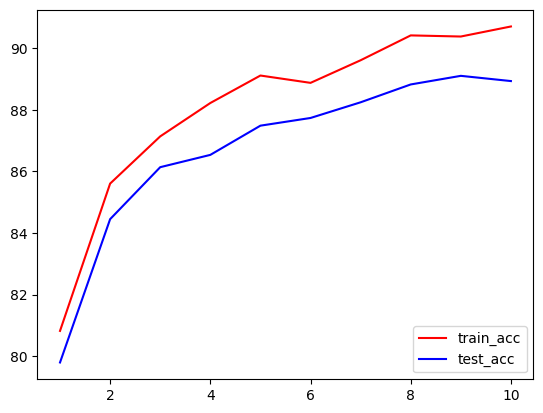


0.001 0 SGD
Fashion-MNIST
iteration # 3
data loaded successfully...
[epoch 1, iter   200] loss: 1.966
[epoch 1, iter   400] loss: 0.981
[epoch 1, iter   600] loss: 0.690
[epoch 1, iter   800] loss: 0.585
epoch 1: train_acc 80.153, test_acc 79.300
[epoch 2, iter   200] loss: 0.509
[epoch 2, iter   400] loss: 0.481
[epoch 2, iter   600] loss: 0.449
[epoch 2, iter   800] loss: 0.443
epoch 2: train_acc 84.047, test_acc 83.080
[epoch 3, iter   200] loss: 0.405
[epoch 3, iter   400] loss: 0.408
[epoch 3, iter   600] loss: 0.384
[epoch 3, iter   800] loss: 0.373
epoch 3: train_acc 86.883, test_acc 85.650
[epoch 4, iter   200] loss: 0.358
[epoch 4, iter   400] loss: 0.356
[epoch 4, iter   600] loss: 0.343
[epoch 4, iter   800] loss: 0.352
epoch 4: train_acc 88.185, test_acc 87.170
[epoch 5, iter   200] loss: 0.326
[epoch 5, iter   400] loss: 0.331
[epoch 5, iter   600] loss: 0.335
[epoch 5, iter   800] loss: 0.319
epoch 5: train_acc 88.950, test_acc 87.710
[epoch 6, iter   200] loss: 0.308
[e

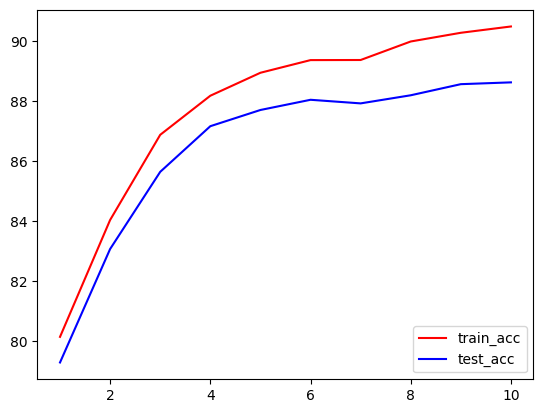


0.001 0 SGD
Fashion-MNIST
iteration # 4
data loaded successfully...
[epoch 1, iter   200] loss: 1.954
[epoch 1, iter   400] loss: 1.003
[epoch 1, iter   600] loss: 0.685
[epoch 1, iter   800] loss: 0.597
epoch 1: train_acc 79.660, test_acc 79.120
[epoch 2, iter   200] loss: 0.512
[epoch 2, iter   400] loss: 0.490
[epoch 2, iter   600] loss: 0.457
[epoch 2, iter   800] loss: 0.431
epoch 2: train_acc 84.673, test_acc 83.460
[epoch 3, iter   200] loss: 0.407
[epoch 3, iter   400] loss: 0.399
[epoch 3, iter   600] loss: 0.384
[epoch 3, iter   800] loss: 0.375
epoch 3: train_acc 87.057, test_acc 85.860
[epoch 4, iter   200] loss: 0.353
[epoch 4, iter   400] loss: 0.364
[epoch 4, iter   600] loss: 0.344
[epoch 4, iter   800] loss: 0.353
epoch 4: train_acc 88.050, test_acc 86.660
[epoch 5, iter   200] loss: 0.336
[epoch 5, iter   400] loss: 0.335
[epoch 5, iter   600] loss: 0.324
[epoch 5, iter   800] loss: 0.327
epoch 5: train_acc 89.087, test_acc 87.330
[epoch 6, iter   200] loss: 0.309
[e

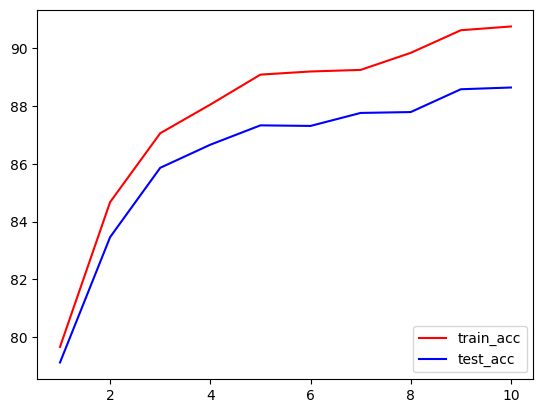


0.001 0 SGD
Fashion-MNIST
iteration # 5
data loaded successfully...
[epoch 1, iter   200] loss: 1.893
[epoch 1, iter   400] loss: 0.976
[epoch 1, iter   600] loss: 0.675
[epoch 1, iter   800] loss: 0.589
epoch 1: train_acc 81.923, test_acc 81.050
[epoch 2, iter   200] loss: 0.483
[epoch 2, iter   400] loss: 0.460
[epoch 2, iter   600] loss: 0.432
[epoch 2, iter   800] loss: 0.425
epoch 2: train_acc 85.707, test_acc 85.050
[epoch 3, iter   200] loss: 0.382
[epoch 3, iter   400] loss: 0.378
[epoch 3, iter   600] loss: 0.366
[epoch 3, iter   800] loss: 0.363
epoch 3: train_acc 87.412, test_acc 86.420
[epoch 4, iter   200] loss: 0.351
[epoch 4, iter   400] loss: 0.340
[epoch 4, iter   600] loss: 0.334
[epoch 4, iter   800] loss: 0.338
epoch 4: train_acc 88.858, test_acc 87.650
[epoch 5, iter   200] loss: 0.317
[epoch 5, iter   400] loss: 0.318
[epoch 5, iter   600] loss: 0.313
[epoch 5, iter   800] loss: 0.325
epoch 5: train_acc 89.488, test_acc 88.060
[epoch 6, iter   200] loss: 0.309
[e

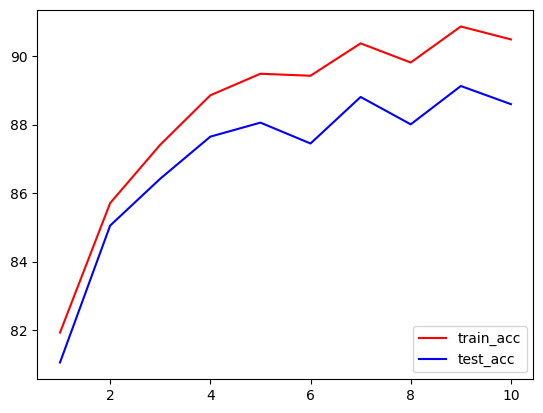


0.001 0.9 SGD
Fashion-MNIST
iteration # 1
data loaded successfully...
[epoch 1, iter   200] loss: 1.965
[epoch 1, iter   400] loss: 1.066
[epoch 1, iter   600] loss: 0.747
[epoch 1, iter   800] loss: 0.649
epoch 1: train_acc 79.580, test_acc 78.660
[epoch 2, iter   200] loss: 0.554
[epoch 2, iter   400] loss: 0.522
[epoch 2, iter   600] loss: 0.493
[epoch 2, iter   800] loss: 0.467
epoch 2: train_acc 84.115, test_acc 83.180
[epoch 3, iter   200] loss: 0.445
[epoch 3, iter   400] loss: 0.428
[epoch 3, iter   600] loss: 0.402
[epoch 3, iter   800] loss: 0.412
epoch 3: train_acc 85.915, test_acc 85.290
[epoch 4, iter   200] loss: 0.392
[epoch 4, iter   400] loss: 0.392
[epoch 4, iter   600] loss: 0.372
[epoch 4, iter   800] loss: 0.369
epoch 4: train_acc 87.178, test_acc 86.360
[epoch 5, iter   200] loss: 0.366
[epoch 5, iter   400] loss: 0.356
[epoch 5, iter   600] loss: 0.357
[epoch 5, iter   800] loss: 0.341
epoch 5: train_acc 87.675, test_acc 86.460
[epoch 6, iter   200] loss: 0.339


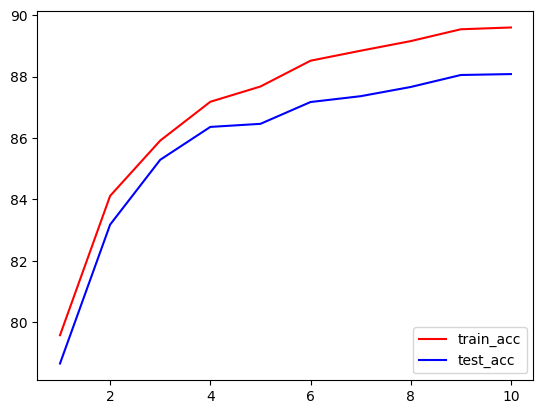


0.001 0.9 SGD
Fashion-MNIST
iteration # 2
data loaded successfully...
[epoch 1, iter   200] loss: 1.906
[epoch 1, iter   400] loss: 0.975
[epoch 1, iter   600] loss: 0.708
[epoch 1, iter   800] loss: 0.591
epoch 1: train_acc 79.982, test_acc 79.330
[epoch 2, iter   200] loss: 0.512
[epoch 2, iter   400] loss: 0.493
[epoch 2, iter   600] loss: 0.467
[epoch 2, iter   800] loss: 0.457
epoch 2: train_acc 84.583, test_acc 83.890
[epoch 3, iter   200] loss: 0.418
[epoch 3, iter   400] loss: 0.415
[epoch 3, iter   600] loss: 0.395
[epoch 3, iter   800] loss: 0.389
epoch 3: train_acc 86.500, test_acc 85.600
[epoch 4, iter   200] loss: 0.376
[epoch 4, iter   400] loss: 0.367
[epoch 4, iter   600] loss: 0.377
[epoch 4, iter   800] loss: 0.347
epoch 4: train_acc 87.472, test_acc 86.190
[epoch 5, iter   200] loss: 0.348
[epoch 5, iter   400] loss: 0.349
[epoch 5, iter   600] loss: 0.347
[epoch 5, iter   800] loss: 0.337
epoch 5: train_acc 88.265, test_acc 86.720
[epoch 6, iter   200] loss: 0.330


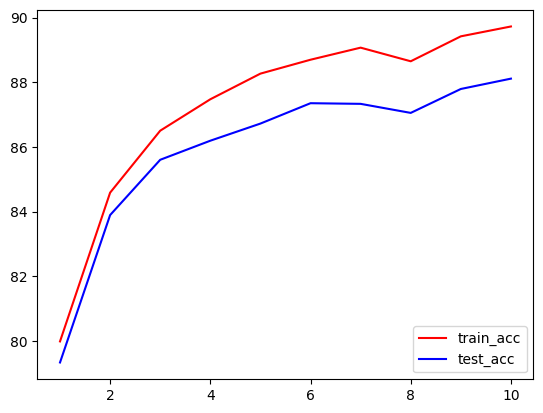


0.001 0.9 SGD
Fashion-MNIST
iteration # 3
data loaded successfully...
[epoch 1, iter   200] loss: 1.998
[epoch 1, iter   400] loss: 1.069
[epoch 1, iter   600] loss: 0.727
[epoch 1, iter   800] loss: 0.602
epoch 1: train_acc 80.633, test_acc 79.950
[epoch 2, iter   200] loss: 0.494
[epoch 2, iter   400] loss: 0.477
[epoch 2, iter   600] loss: 0.457
[epoch 2, iter   800] loss: 0.419
epoch 2: train_acc 85.647, test_acc 84.370
[epoch 3, iter   200] loss: 0.404
[epoch 3, iter   400] loss: 0.395
[epoch 3, iter   600] loss: 0.376
[epoch 3, iter   800] loss: 0.375
epoch 3: train_acc 86.218, test_acc 85.400
[epoch 4, iter   200] loss: 0.348
[epoch 4, iter   400] loss: 0.360
[epoch 4, iter   600] loss: 0.355
[epoch 4, iter   800] loss: 0.351
epoch 4: train_acc 87.968, test_acc 86.850
[epoch 5, iter   200] loss: 0.340
[epoch 5, iter   400] loss: 0.335
[epoch 5, iter   600] loss: 0.335
[epoch 5, iter   800] loss: 0.328
epoch 5: train_acc 88.608, test_acc 87.500
[epoch 6, iter   200] loss: 0.323


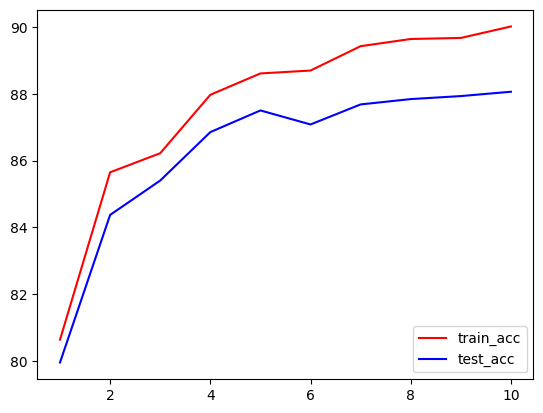


0.001 0.9 SGD
Fashion-MNIST
iteration # 4
data loaded successfully...
[epoch 1, iter   200] loss: 2.010
[epoch 1, iter   400] loss: 1.072
[epoch 1, iter   600] loss: 0.741
[epoch 1, iter   800] loss: 0.634
epoch 1: train_acc 78.707, test_acc 78.510
[epoch 2, iter   200] loss: 0.545
[epoch 2, iter   400] loss: 0.514
[epoch 2, iter   600] loss: 0.489
[epoch 2, iter   800] loss: 0.472
epoch 2: train_acc 83.735, test_acc 83.250
[epoch 3, iter   200] loss: 0.446
[epoch 3, iter   400] loss: 0.424
[epoch 3, iter   600] loss: 0.409
[epoch 3, iter   800] loss: 0.413
epoch 3: train_acc 85.648, test_acc 84.690
[epoch 4, iter   200] loss: 0.395
[epoch 4, iter   400] loss: 0.383
[epoch 4, iter   600] loss: 0.377
[epoch 4, iter   800] loss: 0.375
epoch 4: train_acc 86.955, test_acc 85.770
[epoch 5, iter   200] loss: 0.366
[epoch 5, iter   400] loss: 0.361
[epoch 5, iter   600] loss: 0.353
[epoch 5, iter   800] loss: 0.348
epoch 5: train_acc 87.850, test_acc 86.600
[epoch 6, iter   200] loss: 0.339


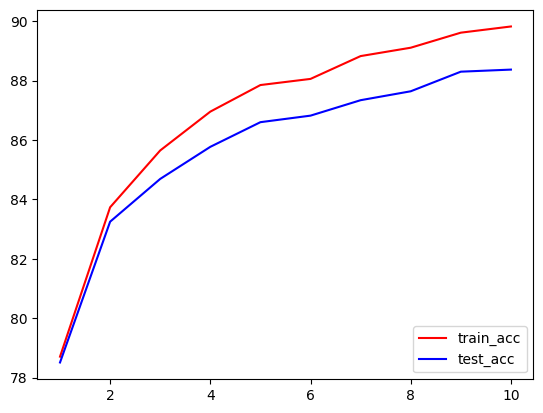


0.001 0.9 SGD
Fashion-MNIST
iteration # 5
data loaded successfully...
[epoch 1, iter   200] loss: 1.982
[epoch 1, iter   400] loss: 1.044
[epoch 1, iter   600] loss: 0.704
[epoch 1, iter   800] loss: 0.602
epoch 1: train_acc 80.697, test_acc 80.210
[epoch 2, iter   200] loss: 0.510
[epoch 2, iter   400] loss: 0.485
[epoch 2, iter   600] loss: 0.457
[epoch 2, iter   800] loss: 0.447
epoch 2: train_acc 85.247, test_acc 84.470
[epoch 3, iter   200] loss: 0.417
[epoch 3, iter   400] loss: 0.402
[epoch 3, iter   600] loss: 0.391
[epoch 3, iter   800] loss: 0.384
epoch 3: train_acc 86.755, test_acc 85.820
[epoch 4, iter   200] loss: 0.372
[epoch 4, iter   400] loss: 0.368
[epoch 4, iter   600] loss: 0.351
[epoch 4, iter   800] loss: 0.354
epoch 4: train_acc 87.780, test_acc 86.980
[epoch 5, iter   200] loss: 0.351
[epoch 5, iter   400] loss: 0.340
[epoch 5, iter   600] loss: 0.335
[epoch 5, iter   800] loss: 0.328
epoch 5: train_acc 88.130, test_acc 86.900
[epoch 6, iter   200] loss: 0.326


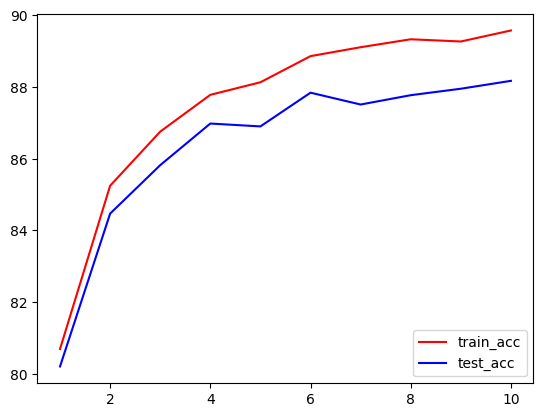


0.01 0 Adam
Fashion-MNIST
iteration # 1
data loaded successfully...
[epoch 1, iter   200] loss: 0.691
[epoch 1, iter   400] loss: 0.457
[epoch 1, iter   600] loss: 0.392
[epoch 1, iter   800] loss: 0.376
epoch 1: train_acc 87.040, test_acc 86.240
[epoch 2, iter   200] loss: 0.338
[epoch 2, iter   400] loss: 0.319
[epoch 2, iter   600] loss: 0.316
[epoch 2, iter   800] loss: 0.322
epoch 2: train_acc 89.440, test_acc 87.900
[epoch 3, iter   200] loss: 0.294
[epoch 3, iter   400] loss: 0.296
[epoch 3, iter   600] loss: 0.292
[epoch 3, iter   800] loss: 0.290
epoch 3: train_acc 89.558, test_acc 87.940
[epoch 4, iter   200] loss: 0.267
[epoch 4, iter   400] loss: 0.271
[epoch 4, iter   600] loss: 0.277
[epoch 4, iter   800] loss: 0.273
epoch 4: train_acc 90.758, test_acc 88.780
[epoch 5, iter   200] loss: 0.258
[epoch 5, iter   400] loss: 0.261
[epoch 5, iter   600] loss: 0.263
[epoch 5, iter   800] loss: 0.257
epoch 5: train_acc 91.282, test_acc 89.380
[epoch 6, iter   200] loss: 0.237
[e

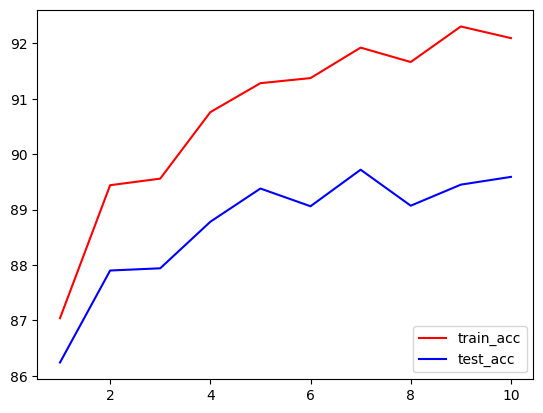


0.01 0 Adam
Fashion-MNIST
iteration # 2
data loaded successfully...
[epoch 1, iter   200] loss: 0.665
[epoch 1, iter   400] loss: 0.457
[epoch 1, iter   600] loss: 0.396
[epoch 1, iter   800] loss: 0.378
epoch 1: train_acc 87.560, test_acc 86.430
[epoch 2, iter   200] loss: 0.340
[epoch 2, iter   400] loss: 0.324
[epoch 2, iter   600] loss: 0.327
[epoch 2, iter   800] loss: 0.325
epoch 2: train_acc 89.188, test_acc 88.200
[epoch 3, iter   200] loss: 0.297
[epoch 3, iter   400] loss: 0.290
[epoch 3, iter   600] loss: 0.306
[epoch 3, iter   800] loss: 0.297
epoch 3: train_acc 90.355, test_acc 88.810
[epoch 4, iter   200] loss: 0.280
[epoch 4, iter   400] loss: 0.277
[epoch 4, iter   600] loss: 0.288
[epoch 4, iter   800] loss: 0.290
epoch 4: train_acc 89.170, test_acc 87.670
[epoch 5, iter   200] loss: 0.274
[epoch 5, iter   400] loss: 0.267
[epoch 5, iter   600] loss: 0.285
[epoch 5, iter   800] loss: 0.262
epoch 5: train_acc 91.212, test_acc 89.400
[epoch 6, iter   200] loss: 0.265
[e

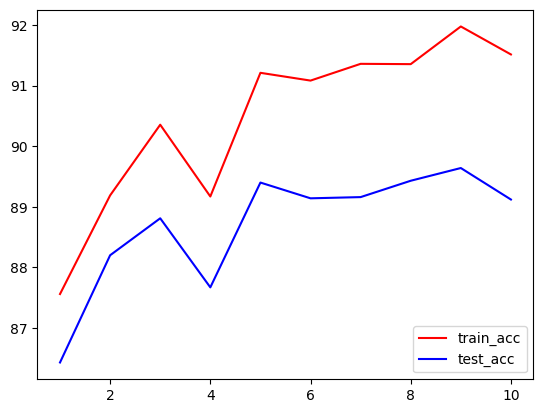


0.01 0 Adam
Fashion-MNIST
iteration # 3
data loaded successfully...
[epoch 1, iter   200] loss: 0.662
[epoch 1, iter   400] loss: 0.448
[epoch 1, iter   600] loss: 0.400
[epoch 1, iter   800] loss: 0.376
epoch 1: train_acc 87.948, test_acc 86.850
[epoch 2, iter   200] loss: 0.343
[epoch 2, iter   400] loss: 0.321
[epoch 2, iter   600] loss: 0.338
[epoch 2, iter   800] loss: 0.333
epoch 2: train_acc 89.257, test_acc 87.970
[epoch 3, iter   200] loss: 0.316
[epoch 3, iter   400] loss: 0.295
[epoch 3, iter   600] loss: 0.303
[epoch 3, iter   800] loss: 0.295
epoch 3: train_acc 89.268, test_acc 87.700
[epoch 4, iter   200] loss: 0.275
[epoch 4, iter   400] loss: 0.287
[epoch 4, iter   600] loss: 0.280
[epoch 4, iter   800] loss: 0.283
epoch 4: train_acc 90.675, test_acc 88.900
[epoch 5, iter   200] loss: 0.262
[epoch 5, iter   400] loss: 0.260
[epoch 5, iter   600] loss: 0.271
[epoch 5, iter   800] loss: 0.272
epoch 5: train_acc 91.145, test_acc 89.360
[epoch 6, iter   200] loss: 0.251
[e

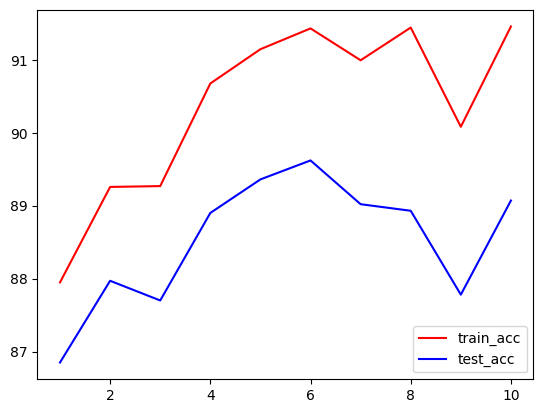


0.01 0 Adam
Fashion-MNIST
iteration # 4
data loaded successfully...
[epoch 1, iter   200] loss: 0.675
[epoch 1, iter   400] loss: 0.470
[epoch 1, iter   600] loss: 0.419
[epoch 1, iter   800] loss: 0.395
epoch 1: train_acc 86.392, test_acc 85.560
[epoch 2, iter   200] loss: 0.352
[epoch 2, iter   400] loss: 0.321
[epoch 2, iter   600] loss: 0.323
[epoch 2, iter   800] loss: 0.317
epoch 2: train_acc 89.095, test_acc 87.950
[epoch 3, iter   200] loss: 0.284
[epoch 3, iter   400] loss: 0.300
[epoch 3, iter   600] loss: 0.292
[epoch 3, iter   800] loss: 0.292
epoch 3: train_acc 90.432, test_acc 88.350
[epoch 4, iter   200] loss: 0.261
[epoch 4, iter   400] loss: 0.272
[epoch 4, iter   600] loss: 0.277
[epoch 4, iter   800] loss: 0.274
epoch 4: train_acc 90.653, test_acc 89.500
[epoch 5, iter   200] loss: 0.254
[epoch 5, iter   400] loss: 0.268
[epoch 5, iter   600] loss: 0.271
[epoch 5, iter   800] loss: 0.270
epoch 5: train_acc 90.500, test_acc 88.940
[epoch 6, iter   200] loss: 0.238
[e

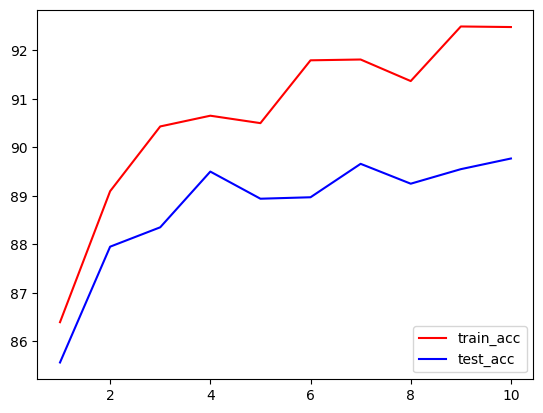


0.01 0 Adam
Fashion-MNIST
iteration # 5
data loaded successfully...
[epoch 1, iter   200] loss: 0.674
[epoch 1, iter   400] loss: 0.462
[epoch 1, iter   600] loss: 0.406
[epoch 1, iter   800] loss: 0.361
epoch 1: train_acc 87.235, test_acc 86.210
[epoch 2, iter   200] loss: 0.325
[epoch 2, iter   400] loss: 0.339
[epoch 2, iter   600] loss: 0.333
[epoch 2, iter   800] loss: 0.316
epoch 2: train_acc 88.025, test_acc 87.080
[epoch 3, iter   200] loss: 0.303
[epoch 3, iter   400] loss: 0.304
[epoch 3, iter   600] loss: 0.285
[epoch 3, iter   800] loss: 0.288
epoch 3: train_acc 90.420, test_acc 89.150
[epoch 4, iter   200] loss: 0.276
[epoch 4, iter   400] loss: 0.262
[epoch 4, iter   600] loss: 0.292
[epoch 4, iter   800] loss: 0.281
epoch 4: train_acc 91.057, test_acc 89.330
[epoch 5, iter   200] loss: 0.265
[epoch 5, iter   400] loss: 0.261
[epoch 5, iter   600] loss: 0.266
[epoch 5, iter   800] loss: 0.271
epoch 5: train_acc 90.775, test_acc 89.340
[epoch 6, iter   200] loss: 0.256
[e

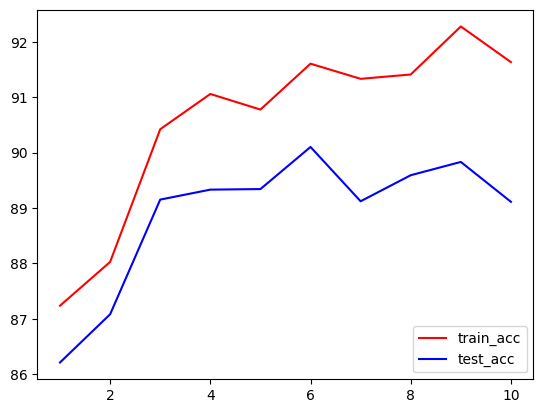


0.001 0 SGD
CIFAR-10
iteration # 1


100%|██████████| 170498071/170498071 [00:08<00:00, 20869651.81it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
data loaded successfully...
[epoch 1, iter   200] loss: 2.261
[epoch 1, iter   400] loss: 2.055
[epoch 1, iter   600] loss: 1.783
epoch 1: train_acc 39.248, test_acc 39.390
[epoch 2, iter   200] loss: 1.604
[epoch 2, iter   400] loss: 1.549
[epoch 2, iter   600] loss: 1.499


In [ ]:
for i in range(3):
  dataset_name = datasets[i]
  for j in range(3):
    learning_rate = learning_rates[j]
    gamma = gammas[j]
    optimizer_name = optimizers[j]
    for k in range(5):
      print(learning_rate, gamma, optimizer_name)
      print(dataset_name)
      print("iteration #", k+1)
      b(learning_rate, optimizer_name, gamma, dataset_name)
      print()

0.01 0.9 SGD
CIFAR-10
iteration # 1
Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...


/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[epoch 1, iter   200] loss: 1.899
[epoch 1, iter   400] loss: 1.527
[epoch 1, iter   600] loss: 1.401
epoch 1: train_acc 52.844, test_acc 52.840
[epoch 2, iter   200] loss: 1.267
[epoch 2, iter   400] loss: 1.227
[epoch 2, iter   600] loss: 1.195
epoch 2: train_acc 57.806, test_acc 56.690
[epoch 3, iter   200] loss: 1.132
[epoch 3, iter   400] loss: 1.107
[epoch 3, iter   600] loss: 1.099
epoch 3: train_acc 63.732, test_acc 61.420
[epoch 4, iter   200] loss: 1.024
[epoch 4, iter   400] loss: 1.049
[epoch 4, iter   600] loss: 1.033
epoch 4: train_acc 65.714, test_acc 63.260
[epoch 5, iter   200] loss: 0.975
[epoch 5, iter   400] loss: 0.969
[epoch 5, iter   600] loss: 0.964
epoch 5: train_acc 68.144, test_acc 64.990
[epoch 6, iter   200] loss: 0.931
[epoch 6, iter   400] loss: 0.919
[epoch 6, iter   600] loss: 0.921
epoch 6: train_acc 69.366, test_acc 65.390
[epoch 7, iter   200] loss: 0.859
[epoch 7, iter   400] loss: 0.880
[epoch 7, iter   600] loss: 0.879
epoch 7: train_acc 70.592, t

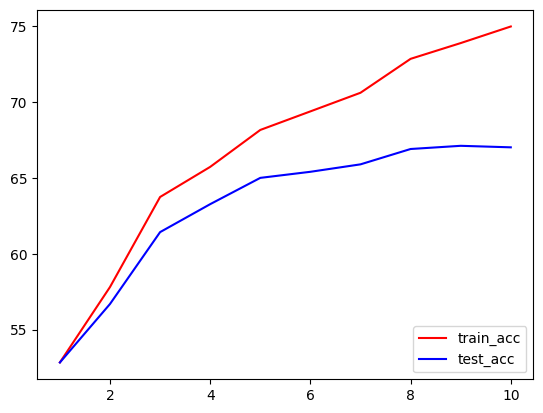


0.01 0.9 SGD
CIFAR-10
iteration # 2
Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...
[epoch 1, iter   200] loss: 1.900
[epoch 1, iter   400] loss: 1.570
[epoch 1, iter   600] loss: 1.459
epoch 1: train_acc 52.674, test_acc 52.100
[epoch 2, iter   200] loss: 1.294
[epoch 2, iter   400] loss: 1.249
[epoch 2, iter   600] loss: 1.231
epoch 2: train_acc 59.464, test_acc 58.280
[epoch 3, iter   200] loss: 1.130
[epoch 3, iter   400] loss: 1.143
[epoch 3, iter   600] loss: 1.102
epoch 3: train_acc 62.260, test_acc 59.700
[epoch 4, iter   200] loss: 1.028
[epoch 4, iter   400] loss: 1.041
[epoch 4, iter   600] loss: 1.016
epoch 4: train_acc 66.564, test_acc 62.800
[epoch 5, iter   200] loss: 0.939
[epoch 5, iter   400] loss: 0.966
[epoch 5, iter   600] loss: 0.977
epoch 5: train_acc 68.030, test_acc 63.990
[epoch 6, iter   200] loss: 0.903
[epoch 6, iter   400] loss: 0.904
[epoch 6, iter   600] loss: 0.917
epoch 6: train_acc 68.932, test_

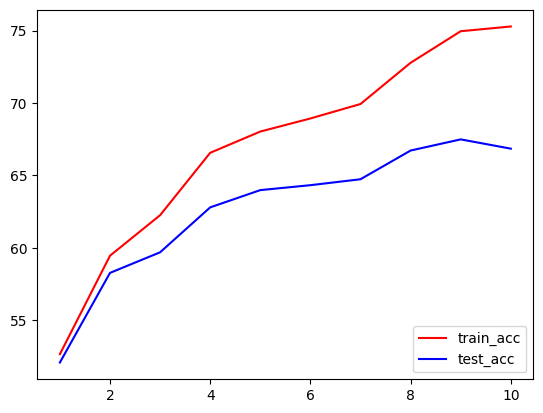


0.01 0.9 SGD
CIFAR-10
iteration # 3
Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...
[epoch 1, iter   200] loss: 1.924
[epoch 1, iter   400] loss: 1.570
[epoch 1, iter   600] loss: 1.420
epoch 1: train_acc 53.964, test_acc 53.940
[epoch 2, iter   200] loss: 1.264
[epoch 2, iter   400] loss: 1.237
[epoch 2, iter   600] loss: 1.224
epoch 2: train_acc 59.478, test_acc 58.090
[epoch 3, iter   200] loss: 1.121
[epoch 3, iter   400] loss: 1.114
[epoch 3, iter   600] loss: 1.103
epoch 3: train_acc 63.542, test_acc 60.930
[epoch 4, iter   200] loss: 1.056
[epoch 4, iter   400] loss: 1.034
[epoch 4, iter   600] loss: 1.034
epoch 4: train_acc 64.856, test_acc 62.160
[epoch 5, iter   200] loss: 0.971
[epoch 5, iter   400] loss: 0.980
[epoch 5, iter   600] loss: 0.974
epoch 5: train_acc 67.930, test_acc 64.250
[epoch 6, iter   200] loss: 0.932
[epoch 6, iter   400] loss: 0.925
[epoch 6, iter   600] loss: 0.915
epoch 6: train_acc 68.682, test_

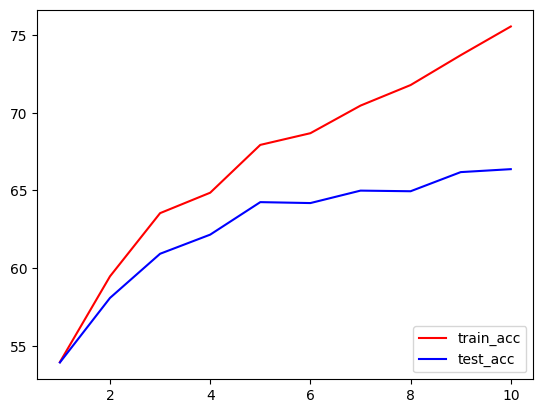


0.01 0.9 SGD
CIFAR-10
iteration # 4
Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...
[epoch 1, iter   200] loss: 1.905
[epoch 1, iter   400] loss: 1.553
[epoch 1, iter   600] loss: 1.443
epoch 1: train_acc 50.546, test_acc 50.580
[epoch 2, iter   200] loss: 1.306
[epoch 2, iter   400] loss: 1.263
[epoch 2, iter   600] loss: 1.260
epoch 2: train_acc 58.860, test_acc 58.280
[epoch 3, iter   200] loss: 1.132
[epoch 3, iter   400] loss: 1.125
[epoch 3, iter   600] loss: 1.128
epoch 3: train_acc 61.874, test_acc 59.670
[epoch 4, iter   200] loss: 1.030
[epoch 4, iter   400] loss: 1.056
[epoch 4, iter   600] loss: 1.072
epoch 4: train_acc 65.752, test_acc 62.780
[epoch 5, iter   200] loss: 0.986
[epoch 5, iter   400] loss: 0.961
[epoch 5, iter   600] loss: 1.005
epoch 5: train_acc 67.596, test_acc 63.380
[epoch 6, iter   200] loss: 0.939
[epoch 6, iter   400] loss: 0.937
[epoch 6, iter   600] loss: 0.923
epoch 6: train_acc 69.060, test_

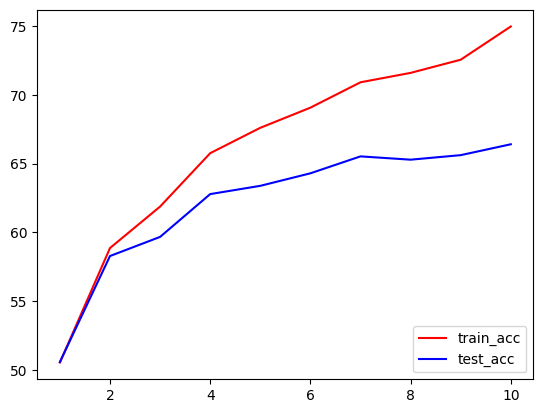


0.01 0.9 SGD
CIFAR-10
iteration # 5
Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...
[epoch 1, iter   200] loss: 1.906
[epoch 1, iter   400] loss: 1.529
[epoch 1, iter   600] loss: 1.445
epoch 1: train_acc 51.080, test_acc 50.790
[epoch 2, iter   200] loss: 1.291
[epoch 2, iter   400] loss: 1.259
[epoch 2, iter   600] loss: 1.223
epoch 2: train_acc 59.146, test_acc 57.630
[epoch 3, iter   200] loss: 1.148
[epoch 3, iter   400] loss: 1.121
[epoch 3, iter   600] loss: 1.098
epoch 3: train_acc 63.252, test_acc 61.310
[epoch 4, iter   200] loss: 1.037
[epoch 4, iter   400] loss: 1.035
[epoch 4, iter   600] loss: 1.032
epoch 4: train_acc 66.264, test_acc 63.010
[epoch 5, iter   200] loss: 0.962
[epoch 5, iter   400] loss: 0.976
[epoch 5, iter   600] loss: 0.974
epoch 5: train_acc 67.288, test_acc 63.630
[epoch 6, iter   200] loss: 0.905
[epoch 6, iter   400] loss: 0.911
[epoch 6, iter   600] loss: 0.939
epoch 6: train_acc 70.182, test_

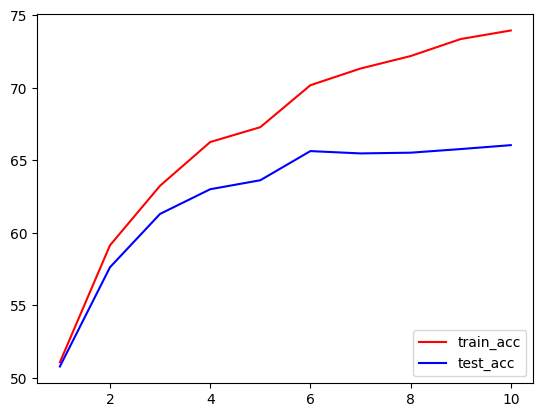

In [ ]:
dataset_name =  "CIFAR-10"
learning_rate = learning_rates[2]
gamma = gammas[1]
optimizer_name = optimizers[0]
for k in range(5):
    print(learning_rate, gamma, optimizer_name)
    print(dataset_name)
    print("iteration #", k+1)
    b(learning_rate, optimizer_name, gamma, dataset_name)
    print("")

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [ ]:
def cf(net, dataset_name, classes):
  train_loader,test_loader=load_data(dataset_name)
  y_pred = []
  y_true = []
  for data in test_loader:
    images,labels = data
    
    outputs = net(images)
    _,predicted=torch.max(outputs.data,1)
    y_true.extend(labels)
    y_pred.extend(predicted)

  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)
  plt.savefig('{}.png'.format(dataset_name))

  return y_pred, y_true

In [ ]:
# Obtained best parameters
params = {}
mnist = {
    "optimizer": "Adam",
    "learning_rates": 0.01,
    "decay": 0,
    "classes": list(i for i in range(10))
}
Fmnist = {
    "optimizer": "Adam",
    "learning_rates": 0.01,
    "decay": 0,
    "classes": ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')
}
cifar10 = {
    "optimizer": "SGD",
    "learning_rates": 0.01,
    "decay": 0.9,
    "classes": ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
}
params["MNIST"] = mnist
params["Fashion-MNIST"] = Fmnist
params["CIFAR-10"] = cifar10


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
MNIST
0.01 0 Adam
iteration # 1
data loaded successfully...
[epoch 1, iter   200] loss: 0.357
[epoch 1, iter   400] loss: 0.120
[epoch 1, iter   600] loss: 0.102
[epoch 1, iter   800] loss: 0.089
epoch 1: train_acc 98.128, test_acc 98.020
[epoch 2, iter   200] loss: 0.068
[epoch 2, iter   400] loss: 0.071
[epoch 2, iter   600] loss: 0.071
[epoch 2, iter   800] loss: 0.057
epoch 2: train_acc 98.463, test_acc 98.220
[epoch 3, iter   200] loss: 0.051
[epoch 3, iter   400] loss: 0.056
[epoch 3, iter   600] loss: 0.058
[epoch 3, iter   800] loss: 0.058
epoch 3: train_acc 98.272, test_acc 98.020
[epoch 4, iter   200] loss: 0.040
[epoch 4, iter   400] loss: 0.049
[epoch 4, iter   600] loss: 0.045
[epoch 4, iter   800] loss: 0.056
epoch 4: train_acc 98.858, test_acc 98.710
[epoch 5, iter   200] loss: 0.039
[epoch 5, iter   400] loss: 0.044
[epoch 5, iter   600] loss: 0.045
[epoch 5, iter   800] loss: 0.052
epoch 5: train_acc 98.657, test_acc 98.260
[epoch 6, iter

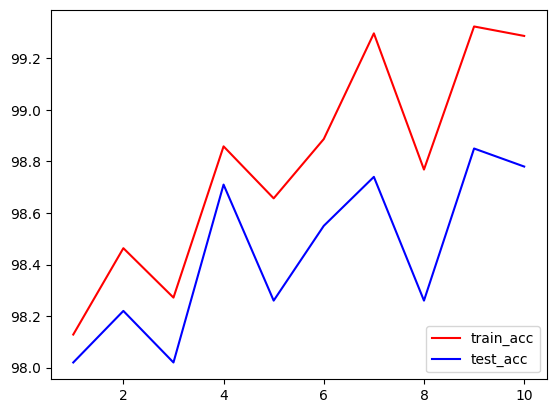


MNIST
0.01 0 Adam
iteration # 2
data loaded successfully...
[epoch 1, iter   200] loss: 0.034
[epoch 1, iter   400] loss: 0.046
[epoch 1, iter   600] loss: 0.031
[epoch 1, iter   800] loss: 0.047
epoch 1: train_acc 99.368, test_acc 98.910
[epoch 2, iter   200] loss: 0.044
[epoch 2, iter   400] loss: 0.036
[epoch 2, iter   600] loss: 0.036
[epoch 2, iter   800] loss: 0.031
epoch 2: train_acc 98.953, test_acc 98.460
[epoch 3, iter   200] loss: 0.031
[epoch 3, iter   400] loss: 0.043
[epoch 3, iter   600] loss: 0.027
[epoch 3, iter   800] loss: 0.030
epoch 3: train_acc 98.948, test_acc 98.390
[epoch 4, iter   200] loss: 0.031
[epoch 4, iter   400] loss: 0.030
[epoch 4, iter   600] loss: 0.040
[epoch 4, iter   800] loss: 0.025
epoch 4: train_acc 99.445, test_acc 98.820
[epoch 5, iter   200] loss: 0.024
[epoch 5, iter   400] loss: 0.032
[epoch 5, iter   600] loss: 0.034
[epoch 5, iter   800] loss: 0.024
epoch 5: train_acc 99.393, test_acc 98.800
[epoch 6, iter   200] loss: 0.025
[epoch 6, 

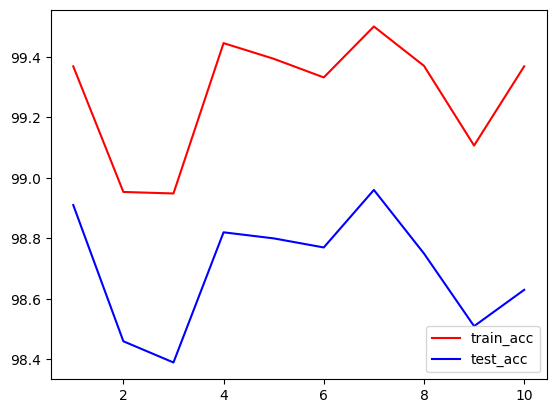


MNIST
0.01 0 Adam
iteration # 3
data loaded successfully...
[epoch 1, iter   200] loss: 0.030
[epoch 1, iter   400] loss: 0.028
[epoch 1, iter   600] loss: 0.042
[epoch 1, iter   800] loss: 0.037
epoch 1: train_acc 99.478, test_acc 98.780
[epoch 2, iter   200] loss: 0.020
[epoch 2, iter   400] loss: 0.025
[epoch 2, iter   600] loss: 0.041
[epoch 2, iter   800] loss: 0.022
epoch 2: train_acc 99.465, test_acc 98.940
[epoch 3, iter   200] loss: 0.031
[epoch 3, iter   400] loss: 0.023
[epoch 3, iter   600] loss: 0.024
[epoch 3, iter   800] loss: 0.015
epoch 3: train_acc 99.442, test_acc 98.960
[epoch 4, iter   200] loss: 0.029
[epoch 4, iter   400] loss: 0.026
[epoch 4, iter   600] loss: 0.038
[epoch 4, iter   800] loss: 0.027
epoch 4: train_acc 99.553, test_acc 99.130
[epoch 5, iter   200] loss: 0.031
[epoch 5, iter   400] loss: 0.022
[epoch 5, iter   600] loss: 0.027
[epoch 5, iter   800] loss: 0.025
epoch 5: train_acc 99.655, test_acc 98.980
[epoch 6, iter   200] loss: 0.018
[epoch 6, 

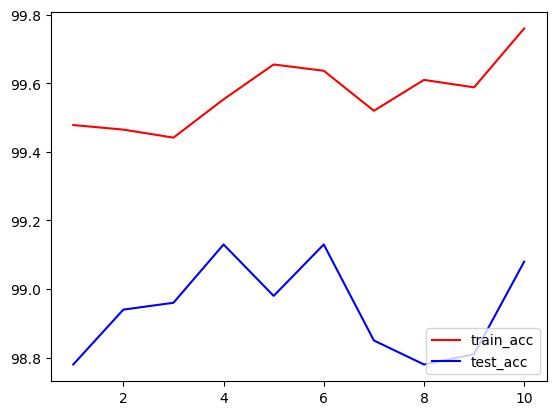


MNIST
0.01 0 Adam
iteration # 4
data loaded successfully...
[epoch 1, iter   200] loss: 0.018
[epoch 1, iter   400] loss: 0.044
[epoch 1, iter   600] loss: 0.027
[epoch 1, iter   800] loss: 0.057
epoch 1: train_acc 99.620, test_acc 99.030
[epoch 2, iter   200] loss: 0.020
[epoch 2, iter   400] loss: 0.048
[epoch 2, iter   600] loss: 0.025
[epoch 2, iter   800] loss: 0.020
epoch 2: train_acc 99.647, test_acc 98.810
[epoch 3, iter   200] loss: 0.021
[epoch 3, iter   400] loss: 0.021
[epoch 3, iter   600] loss: 0.019
[epoch 3, iter   800] loss: 0.019
epoch 3: train_acc 99.622, test_acc 98.860
[epoch 4, iter   200] loss: 0.024
[epoch 4, iter   400] loss: 0.027
[epoch 4, iter   600] loss: 0.015
[epoch 4, iter   800] loss: 0.019
epoch 4: train_acc 99.787, test_acc 99.100
[epoch 5, iter   200] loss: 0.017
[epoch 5, iter   400] loss: 0.023
[epoch 5, iter   600] loss: 0.029
[epoch 5, iter   800] loss: 0.032
epoch 5: train_acc 99.503, test_acc 98.930
[epoch 6, iter   200] loss: 0.020
[epoch 6, 

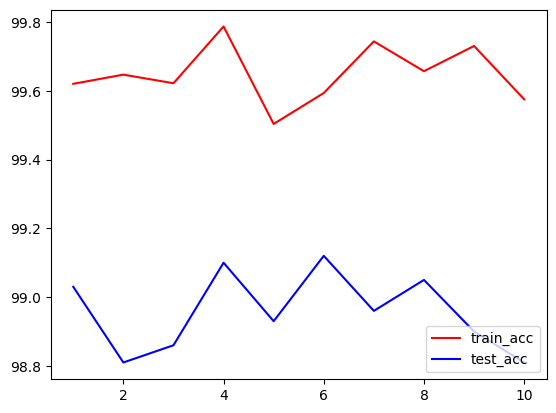


MNIST
0.01 0 Adam
iteration # 5
data loaded successfully...
[epoch 1, iter   200] loss: 0.022
[epoch 1, iter   400] loss: 0.032
[epoch 1, iter   600] loss: 0.041
[epoch 1, iter   800] loss: 0.030
epoch 1: train_acc 99.062, test_acc 98.350
[epoch 2, iter   200] loss: 0.046
[epoch 2, iter   400] loss: 0.043
[epoch 2, iter   600] loss: 0.022
[epoch 2, iter   800] loss: 0.028
epoch 2: train_acc 99.733, test_acc 98.970
[epoch 3, iter   200] loss: 0.014
[epoch 3, iter   400] loss: 0.023
[epoch 3, iter   600] loss: 0.026
[epoch 3, iter   800] loss: 0.022
epoch 3: train_acc 99.678, test_acc 98.830
[epoch 4, iter   200] loss: 0.016
[epoch 4, iter   400] loss: 0.011
[epoch 4, iter   600] loss: 0.012
[epoch 4, iter   800] loss: 0.015
epoch 4: train_acc 99.450, test_acc 98.780
[epoch 5, iter   200] loss: 0.043
[epoch 5, iter   400] loss: 0.033
[epoch 5, iter   600] loss: 0.024
[epoch 5, iter   800] loss: 0.053
epoch 5: train_acc 99.680, test_acc 98.930
[epoch 6, iter   200] loss: 0.017
[epoch 6, 

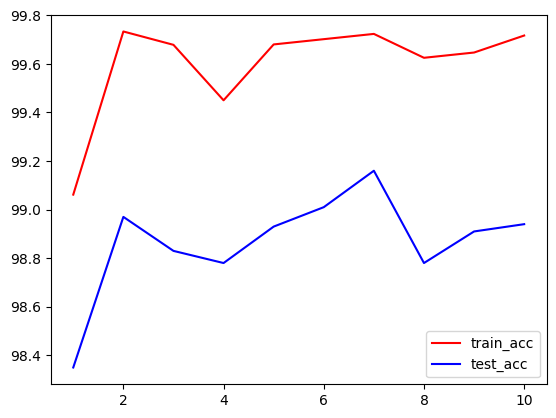


data loaded successfully...
('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')
Fashion-MNIST
0.01 0 Adam
iteration # 1
data loaded successfully...
[epoch 1, iter   200] loss: 0.657
[epoch 1, iter   400] loss: 0.439
[epoch 1, iter   600] loss: 0.417
[epoch 1, iter   800] loss: 0.372
epoch 1: train_acc 87.125, test_acc 86.160
[epoch 2, iter   200] loss: 0.339
[epoch 2, iter   400] loss: 0.332
[epoch 2, iter   600] loss: 0.328
[epoch 2, iter   800] loss: 0.310
epoch 2: train_acc 88.853, test_acc 87.740
[epoch 3, iter   200] loss: 0.299
[epoch 3, iter   400] loss: 0.296
[epoch 3, iter   600] loss: 0.293
[epoch 3, iter   800] loss: 0.295
epoch 3: train_acc 90.505, test_acc 88.990
[epoch 4, iter   200] loss: 0.269
[epoch 4, iter   400] loss: 0.271
[epoch 4, iter   600] loss: 0.280
[epoch 4, iter   800] loss: 0.275
epoch 4: train_acc 90.193, test_acc 89.010
[epoch 5, iter   200] loss: 0.261
[epoch 5, iter   400] loss: 0.256
[epoch 5, it

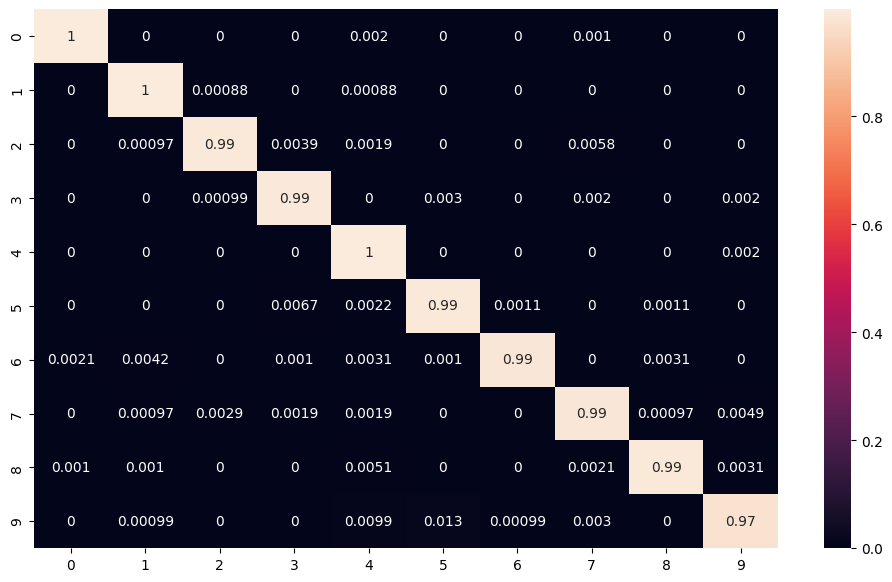

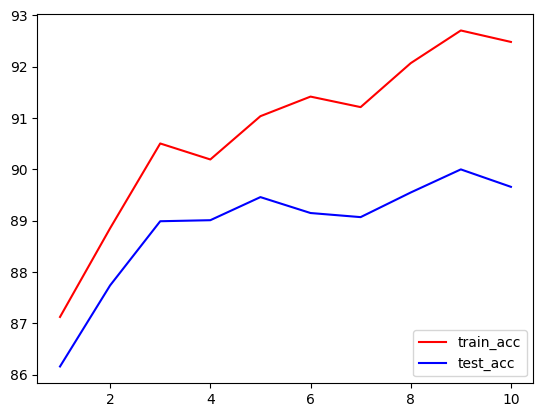


Fashion-MNIST
0.01 0 Adam
iteration # 2
data loaded successfully...
[epoch 1, iter   200] loss: 0.218
[epoch 1, iter   400] loss: 0.230
[epoch 1, iter   600] loss: 0.222
[epoch 1, iter   800] loss: 0.223
epoch 1: train_acc 92.897, test_acc 90.200
[epoch 2, iter   200] loss: 0.204
[epoch 2, iter   400] loss: 0.214
[epoch 2, iter   600] loss: 0.210
[epoch 2, iter   800] loss: 0.212
epoch 2: train_acc 92.873, test_acc 90.150
[epoch 3, iter   200] loss: 0.190
[epoch 3, iter   400] loss: 0.201
[epoch 3, iter   600] loss: 0.205
[epoch 3, iter   800] loss: 0.208
epoch 3: train_acc 92.227, test_acc 89.000
[epoch 4, iter   200] loss: 0.192
[epoch 4, iter   400] loss: 0.197
[epoch 4, iter   600] loss: 0.210
[epoch 4, iter   800] loss: 0.202
epoch 4: train_acc 92.687, test_acc 89.600
[epoch 5, iter   200] loss: 0.192
[epoch 5, iter   400] loss: 0.193
[epoch 5, iter   600] loss: 0.213
[epoch 5, iter   800] loss: 0.214
epoch 5: train_acc 93.418, test_acc 90.310
[epoch 6, iter   200] loss: 0.188
[e

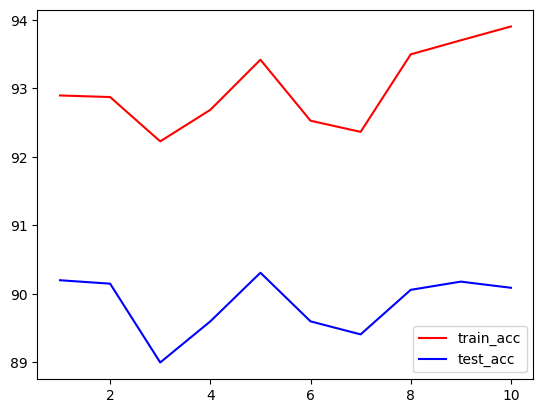


Fashion-MNIST
0.01 0 Adam
iteration # 3
data loaded successfully...
[epoch 1, iter   200] loss: 0.184
[epoch 1, iter   400] loss: 0.189
[epoch 1, iter   600] loss: 0.191
[epoch 1, iter   800] loss: 0.209
epoch 1: train_acc 93.303, test_acc 89.170
[epoch 2, iter   200] loss: 0.171
[epoch 2, iter   400] loss: 0.201
[epoch 2, iter   600] loss: 0.176
[epoch 2, iter   800] loss: 0.181
epoch 2: train_acc 92.830, test_acc 89.190
[epoch 3, iter   200] loss: 0.182
[epoch 3, iter   400] loss: 0.160
[epoch 3, iter   600] loss: 0.182
[epoch 3, iter   800] loss: 0.196
epoch 3: train_acc 94.040, test_acc 89.910
[epoch 4, iter   200] loss: 0.165
[epoch 4, iter   400] loss: 0.183
[epoch 4, iter   600] loss: 0.186
[epoch 4, iter   800] loss: 0.185
epoch 4: train_acc 93.997, test_acc 90.010
[epoch 5, iter   200] loss: 0.169
[epoch 5, iter   400] loss: 0.162
[epoch 5, iter   600] loss: 0.185
[epoch 5, iter   800] loss: 0.173
epoch 5: train_acc 93.970, test_acc 90.060
[epoch 6, iter   200] loss: 0.164
[e

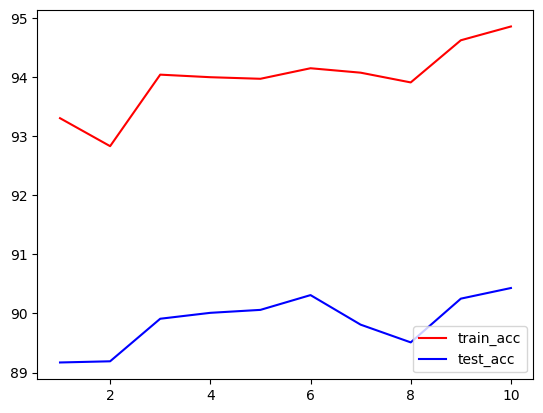


Fashion-MNIST
0.01 0 Adam
iteration # 4
data loaded successfully...
[epoch 1, iter   200] loss: 0.155
[epoch 1, iter   400] loss: 0.168
[epoch 1, iter   600] loss: 0.201
[epoch 1, iter   800] loss: 0.200
epoch 1: train_acc 94.198, test_acc 90.210
[epoch 2, iter   200] loss: 0.147
[epoch 2, iter   400] loss: 0.186
[epoch 2, iter   600] loss: 0.162
[epoch 2, iter   800] loss: 0.180
epoch 2: train_acc 94.347, test_acc 90.030
[epoch 3, iter   200] loss: 0.168
[epoch 3, iter   400] loss: 0.165
[epoch 3, iter   600] loss: 0.161
[epoch 3, iter   800] loss: 0.181
epoch 3: train_acc 93.955, test_acc 89.710
[epoch 4, iter   200] loss: 0.142
[epoch 4, iter   400] loss: 0.157
[epoch 4, iter   600] loss: 0.156
[epoch 4, iter   800] loss: 0.179
epoch 4: train_acc 94.558, test_acc 89.560
[epoch 5, iter   200] loss: 0.156
[epoch 5, iter   400] loss: 0.153
[epoch 5, iter   600] loss: 0.161
[epoch 5, iter   800] loss: 0.211
epoch 5: train_acc 94.353, test_acc 90.450
[epoch 6, iter   200] loss: 0.162
[e

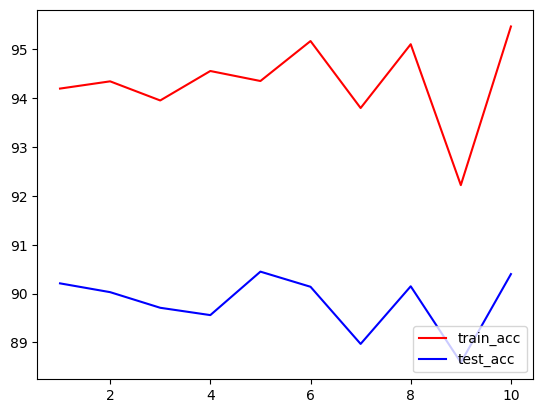


Fashion-MNIST
0.01 0 Adam
iteration # 5
data loaded successfully...
[epoch 1, iter   200] loss: 0.153
[epoch 1, iter   400] loss: 0.177
[epoch 1, iter   600] loss: 0.194
[epoch 1, iter   800] loss: 0.164
epoch 1: train_acc 94.563, test_acc 89.600
[epoch 2, iter   200] loss: 0.144
[epoch 2, iter   400] loss: 0.135
[epoch 2, iter   600] loss: 0.143
[epoch 2, iter   800] loss: 0.163
epoch 2: train_acc 93.655, test_acc 89.020
[epoch 3, iter   200] loss: 0.161
[epoch 3, iter   400] loss: 0.170
[epoch 3, iter   600] loss: 0.184
[epoch 3, iter   800] loss: 0.212
epoch 3: train_acc 94.645, test_acc 89.500
[epoch 4, iter   200] loss: 0.157
[epoch 4, iter   400] loss: 0.156
[epoch 4, iter   600] loss: 0.133
[epoch 4, iter   800] loss: 0.182
epoch 4: train_acc 94.715, test_acc 89.510
[epoch 5, iter   200] loss: 0.148
[epoch 5, iter   400] loss: 0.145
[epoch 5, iter   600] loss: 0.145
[epoch 5, iter   800] loss: 0.158
epoch 5: train_acc 91.167, test_acc 87.810
[epoch 6, iter   200] loss: 0.169
[e

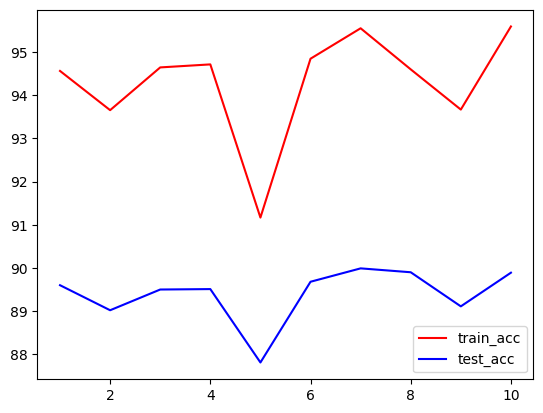


data loaded successfully...
('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
CIFAR-10
0.01 0.9 SGD
iteration # 1
Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...


/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[epoch 1, iter   200] loss: 1.875
[epoch 1, iter   400] loss: 1.534
[epoch 1, iter   600] loss: 1.420
epoch 1: train_acc 52.746, test_acc 52.730
[epoch 2, iter   200] loss: 1.270
[epoch 2, iter   400] loss: 1.245
[epoch 2, iter   600] loss: 1.231
epoch 2: train_acc 60.128, test_acc 58.990
[epoch 3, iter   200] loss: 1.125
[epoch 3, iter   400] loss: 1.090
[epoch 3, iter   600] loss: 1.122
epoch 3: train_acc 63.572, test_acc 61.650
[epoch 4, iter   200] loss: 1.032
[epoch 4, iter   400] loss: 1.023
[epoch 4, iter   600] loss: 1.019
epoch 4: train_acc 66.260, test_acc 62.870
[epoch 5, iter   200] loss: 0.962
[epoch 5, iter   400] loss: 0.969
[epoch 5, iter   600] loss: 0.966
epoch 5: train_acc 68.834, test_acc 64.770
[epoch 6, iter   200] loss: 0.889
[epoch 6, iter   400] loss: 0.904
[epoch 6, iter   600] loss: 0.908
epoch 6: train_acc 70.562, test_acc 65.870
[epoch 7, iter   200] loss: 0.846
[epoch 7, iter   400] loss: 0.865
[epoch 7, iter   600] loss: 0.845
epoch 7: train_acc 71.882, t

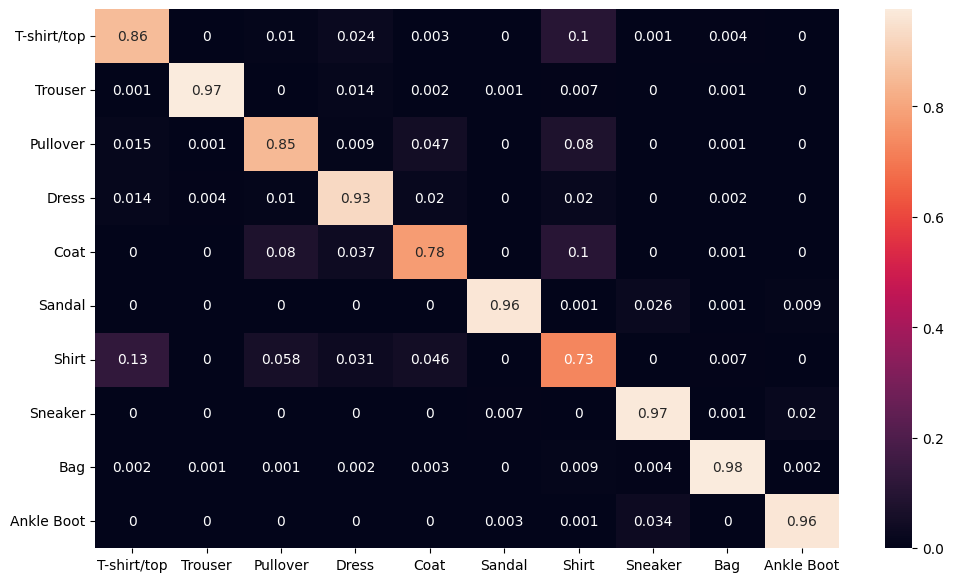

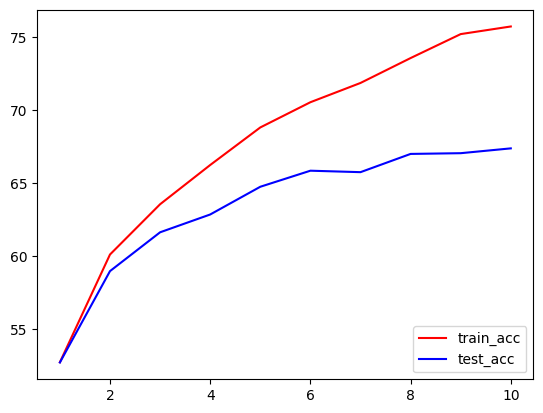


CIFAR-10
0.01 0.9 SGD
iteration # 2
Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...
[epoch 1, iter   200] loss: 0.818
[epoch 1, iter   400] loss: 0.858
[epoch 1, iter   600] loss: 0.857
epoch 1: train_acc 74.190, test_acc 67.020
[epoch 2, iter   200] loss: 0.748
[epoch 2, iter   400] loss: 0.776
[epoch 2, iter   600] loss: 0.793
epoch 2: train_acc 74.512, test_acc 66.040
[epoch 3, iter   200] loss: 0.716
[epoch 3, iter   400] loss: 0.723
[epoch 3, iter   600] loss: 0.742
epoch 3: train_acc 77.252, test_acc 67.020
[epoch 4, iter   200] loss: 0.657
[epoch 4, iter   400] loss: 0.678
[epoch 4, iter   600] loss: 0.709
epoch 4: train_acc 77.920, test_acc 66.900
[epoch 5, iter   200] loss: 0.603
[epoch 5, iter   400] loss: 0.636
[epoch 5, iter   600] loss: 0.648
epoch 5: train_acc 79.382, test_acc 67.680
[epoch 6, iter   200] loss: 0.588
[epoch 6, iter   400] loss: 0.599
[epoch 6, iter   600] loss: 0.605
epoch 6: train_acc 80.282, test_

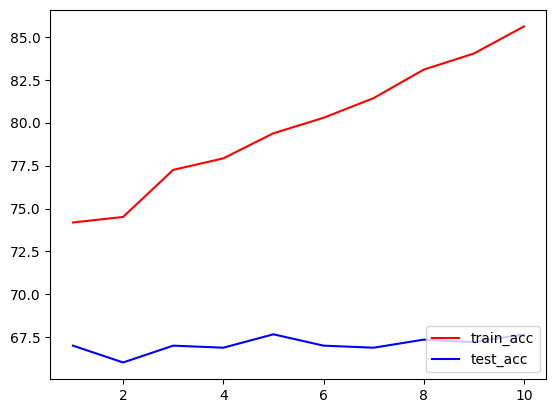


CIFAR-10
0.01 0.9 SGD
iteration # 3
Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...
[epoch 1, iter   200] loss: 0.577
[epoch 1, iter   400] loss: 0.620
[epoch 1, iter   600] loss: 0.662
epoch 1: train_acc 80.320, test_acc 66.020
[epoch 2, iter   200] loss: 0.552
[epoch 2, iter   400] loss: 0.566
[epoch 2, iter   600] loss: 0.587
epoch 2: train_acc 82.474, test_acc 65.610
[epoch 3, iter   200] loss: 0.500
[epoch 3, iter   400] loss: 0.531
[epoch 3, iter   600] loss: 0.565
epoch 3: train_acc 83.108, test_acc 65.530
[epoch 4, iter   200] loss: 0.463
[epoch 4, iter   400] loss: 0.480
[epoch 4, iter   600] loss: 0.528
epoch 4: train_acc 85.328, test_acc 66.420
[epoch 5, iter   200] loss: 0.432
[epoch 5, iter   400] loss: 0.454
[epoch 5, iter   600] loss: 0.468
epoch 5: train_acc 84.198, test_acc 65.320
[epoch 6, iter   200] loss: 0.393
[epoch 6, iter   400] loss: 0.414
[epoch 6, iter   600] loss: 0.432
epoch 6: train_acc 87.918, test_

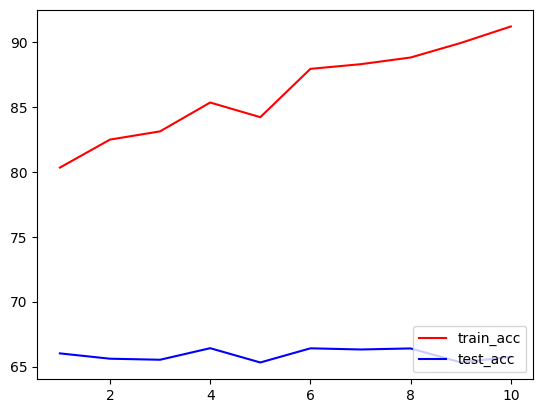


CIFAR-10
0.01 0.9 SGD
iteration # 4
Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...
[epoch 1, iter   200] loss: 0.437
[epoch 1, iter   400] loss: 0.529
[epoch 1, iter   600] loss: 0.564
epoch 1: train_acc 83.666, test_acc 63.790
[epoch 2, iter   200] loss: 0.430
[epoch 2, iter   400] loss: 0.460
[epoch 2, iter   600] loss: 0.456
epoch 2: train_acc 86.046, test_acc 64.480
[epoch 3, iter   200] loss: 0.357
[epoch 3, iter   400] loss: 0.404
[epoch 3, iter   600] loss: 0.426
epoch 3: train_acc 86.946, test_acc 64.360
[epoch 4, iter   200] loss: 0.346
[epoch 4, iter   400] loss: 0.357
[epoch 4, iter   600] loss: 0.370
epoch 4: train_acc 87.370, test_acc 64.440
[epoch 5, iter   200] loss: 0.304
[epoch 5, iter   400] loss: 0.334
[epoch 5, iter   600] loss: 0.340
epoch 5: train_acc 90.034, test_acc 65.270
[epoch 6, iter   200] loss: 0.283
[epoch 6, iter   400] loss: 0.292
[epoch 6, iter   600] loss: 0.310
epoch 6: train_acc 90.582, test_

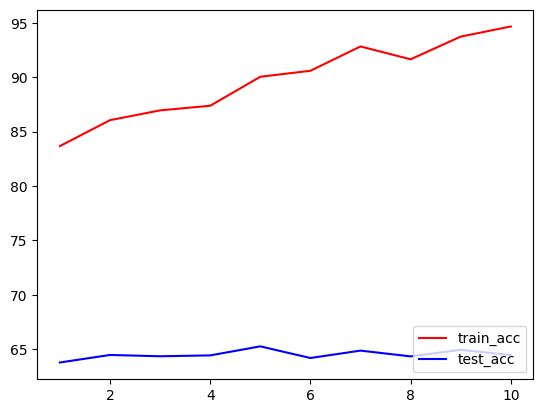


CIFAR-10
0.01 0.9 SGD
iteration # 5
Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...
[epoch 1, iter   200] loss: 0.361
[epoch 1, iter   400] loss: 0.457
[epoch 1, iter   600] loss: 0.486
epoch 1: train_acc 85.100, test_acc 62.680
[epoch 2, iter   200] loss: 0.350
[epoch 2, iter   400] loss: 0.375
[epoch 2, iter   600] loss: 0.400
epoch 2: train_acc 89.348, test_acc 63.370
[epoch 3, iter   200] loss: 0.287
[epoch 3, iter   400] loss: 0.321
[epoch 3, iter   600] loss: 0.338
epoch 3: train_acc 90.400, test_acc 63.690
[epoch 4, iter   200] loss: 0.256
[epoch 4, iter   400] loss: 0.267
[epoch 4, iter   600] loss: 0.286
epoch 4: train_acc 91.360, test_acc 64.160
[epoch 5, iter   200] loss: 0.223
[epoch 5, iter   400] loss: 0.231
[epoch 5, iter   600] loss: 0.267
epoch 5: train_acc 93.444, test_acc 64.950
[epoch 6, iter   200] loss: 0.194
[epoch 6, iter   400] loss: 0.201
[epoch 6, iter   600] loss: 0.235
epoch 6: train_acc 93.962, test_

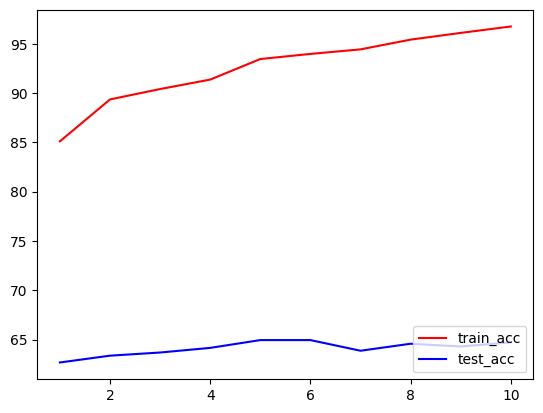


Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...


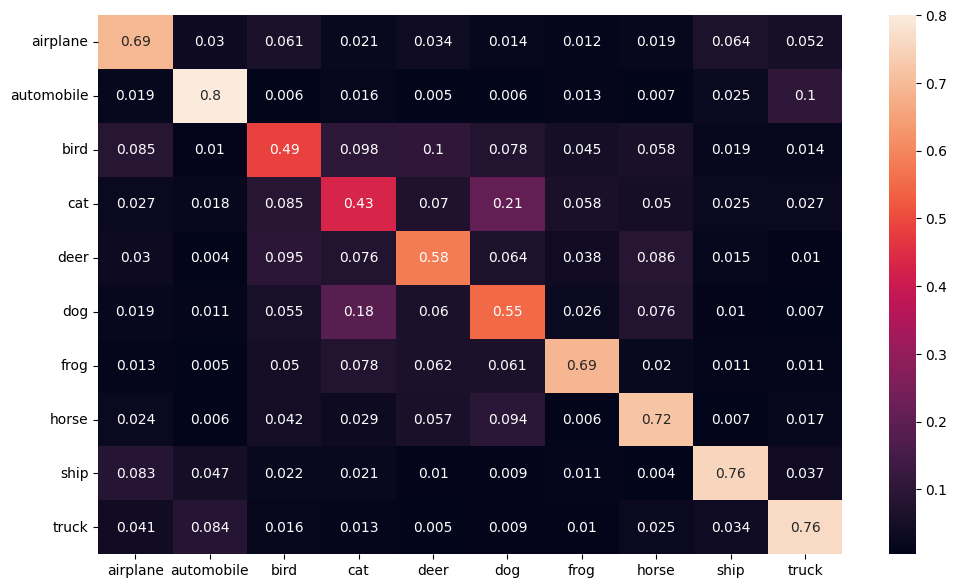

In [ ]:
datasets = ["MNIST","Fashion-MNIST", "CIFAR-10"]

prediction_results = {}
prediction_results["MNIST"] = {
    "y_pred": [],
    "y_true": []
}
prediction_results["Fashion-MNIST"] = {
    "y_pred": [],
    "y_true": []
}
prediction_results["CIFAR-10"] = {
    "y_pred": []
    "y_true": []
}

for dataset_name in datasets:
  # parameter setup
  net = LeNet5(data=dataset_name)
  optimizer_name = params[dataset_name]["optimizer"]
  learning_rate = params[dataset_name]["learning_rates"]
  gamma = params[dataset_name]["decay"]
  classes = params[dataset_name]["classes"]
  print(classes)
  # training
  for k in range(5):
    print(dataset_name)
    print(learning_rate, gamma, optimizer_name)
    print("iteration #", k+1)
    net = b(net, learning_rate, optimizer_name, gamma, dataset_name)
    print()
  y_pred, y_true = cf(net, dataset_name, classes)
  prediction_results[dataset_name]["y_pred"] = y_pred
  prediction_results[dataset_name]["y_true"] = y_true


data loaded successfully...
data loaded successfully...
Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...


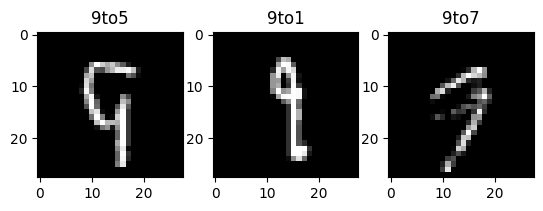

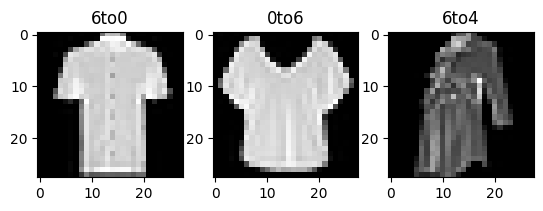

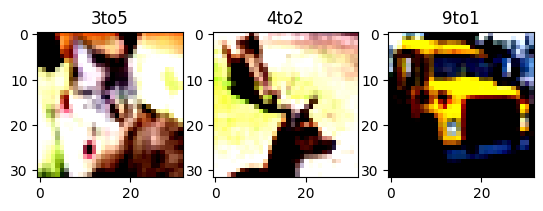

In [ ]:
from pandas.core.indexers.utils import check_key_length
from skimage import data, io
# show confusing example

cfprs_MNIST = [(9,7), (9,5), (9,1)]
cfprs_fMNIST = [(6,0), (0,6), (6,4)]
cfprs_CIFAR = [(3,5), (4,2), (9,1)]

cfprs = [cfprs_MNIST, cfprs_fMNIST, cfprs_CIFAR]

cnt = 1
for k, dataset_name in enumerate(datasets):
  _,test_loader=load_data(dataset_name=dataset_name)
  one, two, three = cfprs[k]
  check1, check2, check3 = False, False, False
  preds = prediction_results[dataset_name]["y_pred"] 
  trues = prediction_results[dataset_name]["y_true"] 
  fig = plt.figure(figsize=(20, 20))
  rows = 9
  columns = 9
  for i, data in enumerate(test_loader):
    if check1 and check2 and check3:
      break
    target_preds = preds[i*1000: i*1000+1000]
    # target_trues = preds[i*1000: i*1000+1000]
    images,labels = data
    for j, label in enumerate(labels):
      if (label, target_preds[j]) == one and not check1: 
        fig.add_subplot(rows, columns, cnt)
        cnt+=1
        check1 = True
        if k < 2:
          plt.imshow(images[j].permute(1, 2, 0), cmap='gray')
        else:
          plt.imshow(images[j].permute(1, 2, 0))
        plt.title("{}to{}".format(label, target_preds[j]))
      if (label, target_preds[j]) == two and not check2:
        fig.add_subplot(rows, columns, cnt)
        cnt+=1
        check2 = True
        if k < 2:
          plt.imshow(images[j].permute(1, 2, 0), cmap='gray')
        else:
          plt.imshow(images[j].permute(1, 2, 0))
        plt.title("{}to{}".format(label, target_preds[j]))
      if (label, target_preds[j]) == three and not check3:
        fig.add_subplot(rows, columns, cnt)
        cnt+=1
        check3 = True
        if k < 2:
          plt.imshow(images[j].permute(1, 2, 0), cmap='gray')
        else:
          plt.imshow(images[j].permute(1, 2, 0))
        plt.title("{}to{}".format(label, target_preds[j]))
        

      



In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier

('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
CIFAR-10
0.01 0.9 SGD
iteration # 1
Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...


/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[epoch 1, iter   200] loss: 1.904
[epoch 1, iter   400] loss: 1.576
[epoch 1, iter   600] loss: 1.435
epoch 1: train_acc 52.446, test_acc 52.240
[epoch 2, iter   200] loss: 1.316
[epoch 2, iter   400] loss: 1.259
[epoch 2, iter   600] loss: 1.230
epoch 2: train_acc 56.890, test_acc 55.390
[epoch 3, iter   200] loss: 1.158
[epoch 3, iter   400] loss: 1.133
[epoch 3, iter   600] loss: 1.131
epoch 3: train_acc 61.672, test_acc 59.100
[epoch 4, iter   200] loss: 1.050
[epoch 4, iter   400] loss: 1.051
[epoch 4, iter   600] loss: 1.063
epoch 4: train_acc 64.702, test_acc 62.140
[epoch 5, iter   200] loss: 0.977
[epoch 5, iter   400] loss: 0.989
[epoch 5, iter   600] loss: 0.996
epoch 5: train_acc 66.806, test_acc 63.720
[epoch 6, iter   200] loss: 0.930
[epoch 6, iter   400] loss: 0.934
[epoch 6, iter   600] loss: 0.944
epoch 6: train_acc 69.538, test_acc 64.920
[epoch 7, iter   200] loss: 0.880
[epoch 7, iter   400] loss: 0.889
[epoch 7, iter   600] loss: 0.876
epoch 7: train_acc 70.456, t

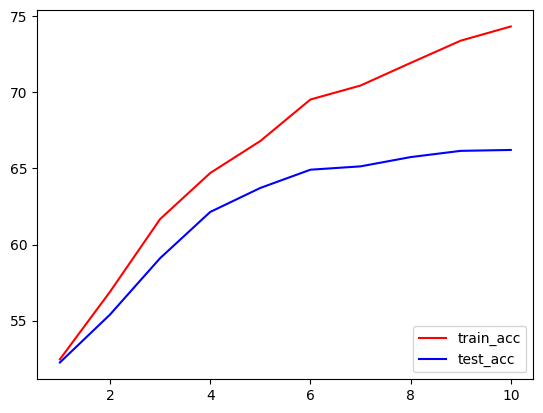


CIFAR-10
0.01 0.9 SGD
iteration # 2
Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...
[epoch 1, iter   200] loss: 0.834
[epoch 1, iter   400] loss: 0.900
[epoch 1, iter   600] loss: 0.891
epoch 1: train_acc 72.992, test_acc 66.030
[epoch 2, iter   200] loss: 0.790
[epoch 2, iter   400] loss: 0.820
[epoch 2, iter   600] loss: 0.825
epoch 2: train_acc 73.018, test_acc 64.590
[epoch 3, iter   200] loss: 0.742
[epoch 3, iter   400] loss: 0.750
[epoch 3, iter   600] loss: 0.770
epoch 3: train_acc 73.342, test_acc 64.400
[epoch 4, iter   200] loss: 0.690
[epoch 4, iter   400] loss: 0.716
[epoch 4, iter   600] loss: 0.750
epoch 4: train_acc 76.264, test_acc 66.230
[epoch 5, iter   200] loss: 0.669
[epoch 5, iter   400] loss: 0.683
[epoch 5, iter   600] loss: 0.690
epoch 5: train_acc 78.782, test_acc 66.800
[epoch 6, iter   200] loss: 0.620
[epoch 6, iter   400] loss: 0.640
[epoch 6, iter   600] loss: 0.663
epoch 6: train_acc 79.308, test_

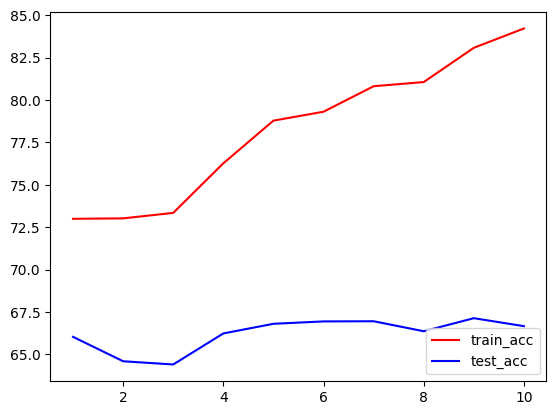


CIFAR-10
0.01 0.9 SGD
iteration # 3
Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...
[epoch 1, iter   200] loss: 0.616
[epoch 1, iter   400] loss: 0.658
[epoch 1, iter   600] loss: 0.698
epoch 1: train_acc 78.406, test_acc 65.030
[epoch 2, iter   200] loss: 0.593
[epoch 2, iter   400] loss: 0.611
[epoch 2, iter   600] loss: 0.626
epoch 2: train_acc 80.878, test_acc 65.060
[epoch 3, iter   200] loss: 0.536
[epoch 3, iter   400] loss: 0.570
[epoch 3, iter   600] loss: 0.581
epoch 3: train_acc 82.668, test_acc 65.810
[epoch 4, iter   200] loss: 0.496
[epoch 4, iter   400] loss: 0.511
[epoch 4, iter   600] loss: 0.540
epoch 4: train_acc 84.504, test_acc 66.190
[epoch 5, iter   200] loss: 0.463
[epoch 5, iter   400] loss: 0.486
[epoch 5, iter   600] loss: 0.497
epoch 5: train_acc 84.848, test_acc 65.390
[epoch 6, iter   200] loss: 0.420
[epoch 6, iter   400] loss: 0.461
[epoch 6, iter   600] loss: 0.467
epoch 6: train_acc 85.344, test_

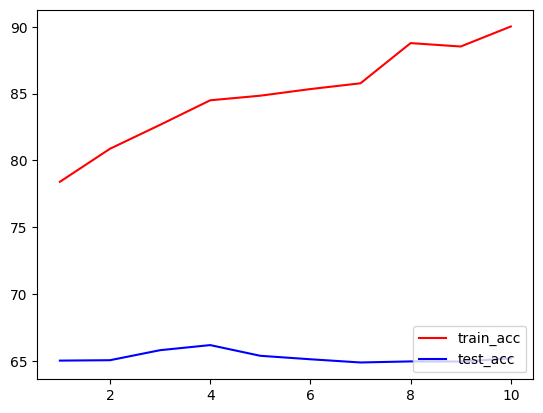


CIFAR-10
0.01 0.9 SGD
iteration # 4
Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...
[epoch 1, iter   200] loss: 0.484
[epoch 1, iter   400] loss: 0.564
[epoch 1, iter   600] loss: 0.582
epoch 1: train_acc 80.390, test_acc 62.940
[epoch 2, iter   200] loss: 0.462
[epoch 2, iter   400] loss: 0.474
[epoch 2, iter   600] loss: 0.499
epoch 2: train_acc 85.250, test_acc 64.400
[epoch 3, iter   200] loss: 0.385
[epoch 3, iter   400] loss: 0.427
[epoch 3, iter   600] loss: 0.470
epoch 3: train_acc 86.778, test_acc 64.450
[epoch 4, iter   200] loss: 0.375
[epoch 4, iter   400] loss: 0.365
[epoch 4, iter   600] loss: 0.404
epoch 4: train_acc 88.548, test_acc 64.810
[epoch 5, iter   200] loss: 0.344
[epoch 5, iter   400] loss: 0.354
[epoch 5, iter   600] loss: 0.364
epoch 5: train_acc 88.958, test_acc 64.630
[epoch 6, iter   200] loss: 0.301
[epoch 6, iter   400] loss: 0.324
[epoch 6, iter   600] loss: 0.320
epoch 6: train_acc 90.560, test_

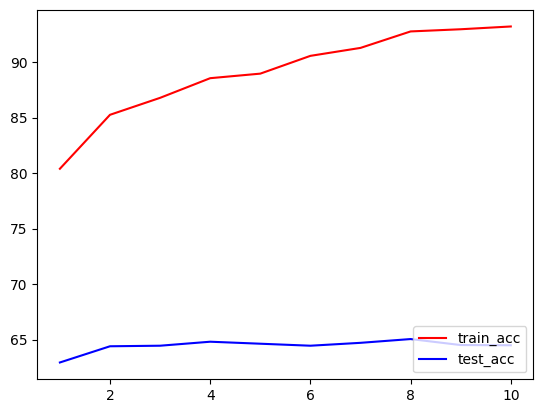


CIFAR-10
0.01 0.9 SGD
iteration # 5
Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...
[epoch 1, iter   200] loss: 0.371
[epoch 1, iter   400] loss: 0.469
[epoch 1, iter   600] loss: 0.523
epoch 1: train_acc 85.724, test_acc 62.910
[epoch 2, iter   200] loss: 0.368
[epoch 2, iter   400] loss: 0.416
[epoch 2, iter   600] loss: 0.430
epoch 2: train_acc 87.850, test_acc 63.410
[epoch 3, iter   200] loss: 0.310
[epoch 3, iter   400] loss: 0.349
[epoch 3, iter   600] loss: 0.361
epoch 3: train_acc 89.196, test_acc 63.290
[epoch 4, iter   200] loss: 0.287
[epoch 4, iter   400] loss: 0.306
[epoch 4, iter   600] loss: 0.315
epoch 4: train_acc 89.892, test_acc 63.540
[epoch 5, iter   200] loss: 0.251
[epoch 5, iter   400] loss: 0.249
[epoch 5, iter   600] loss: 0.272
epoch 5: train_acc 92.154, test_acc 63.890
[epoch 6, iter   200] loss: 0.214
[epoch 6, iter   400] loss: 0.231
[epoch 6, iter   600] loss: 0.251
epoch 6: train_acc 92.702, test_

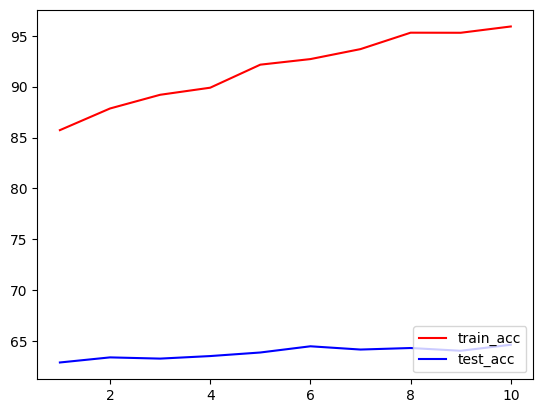


Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...
(1000, 10)


<ipython-input-58-cf4b1da9bf83>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_score = F.softmax(net(images))


In [ ]:
dataset_name = "CIFAR-10"
net = LeNet5(data=dataset_name)
optimizer_name = params[dataset_name]["optimizer"]
learning_rate = params[dataset_name]["learning_rates"]
gamma = params[dataset_name]["decay"]
classes = params[dataset_name]["classes"]
print(classes)
# training
for k in range(5):
  print(dataset_name)
  print(learning_rate, gamma, optimizer_name)
  print("iteration #", k+1)
  net = b(net, learning_rate, optimizer_name, gamma, dataset_name)
  print()

from sklearn.preprocessing import LabelBinarizer
label_binarizer = None

train_loader,test_loader=load_data(dataset_name)

y_score = None
labels = None
for data in test_loader:
  images,labels = data
  y_score = F.softmax(net(images))
  break


label_binarizer = LabelBinarizer().fit([0,1,2,3,4,5,6,7,8,9])
y_onehot_test = label_binarizer.transform(labels)
print(y_onehot_test.shape) 


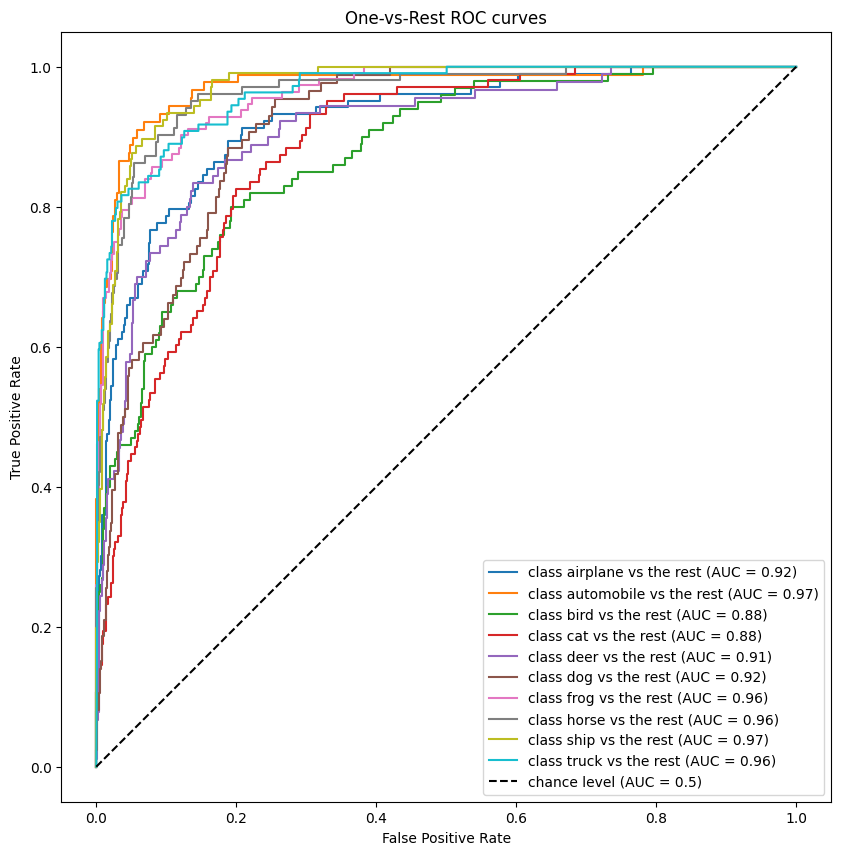

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(10, 10))
for i in range(10):
  name_ =  params["CIFAR-10"]["classes"][i]
  RocCurveDisplay.from_predictions(
      y_onehot_test[:, i],
      y_score[:, i].detach().numpy(),
      name=f"class {  name_} vs the rest",
      # color="darkorange",
      ax = ax
  )

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
print(type(labels))
print(type(y_score))
micro_roc_auc_ovr = roc_auc_score(
    labels.numpy(),
    y_score.detach().numpy(),
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

<class 'torch.Tensor'>
<class 'torch.Tensor'>
Micro-averaged One-vs-Rest ROC AUC score:
0.94


In [ ]:
class NoiseDataset(torch.utils.data.Dataset):
  def __init__(self, x, y):
    super(NoiseDataset, self).__init__()
    # store the raw tensors
    self._x = x
    self._y = y

  def __len__(self):
    # a DataSet must know it size
    return len(self._x)

  def __getitem__(self, index):
    x = self._x[index]
    y = self._y[index]
    return x, y

In [ ]:
def sln_data(epsilon):
    transform=transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.28604,), (0.35302,))])
      
    train_set=tv.datasets.FashionMNIST(
      root='./data',
      train=True,
      download=True,
      transform=transform,
    )
      
    test_set=tv.datasets.FashionMNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )

    tt = []
    for x in train_set:
      image, label = x
      tt.append(image)

    labels = train_set.targets
    print(labels)
    noise_count = [int(torch.bincount(train_set.targets)[i] * epsilon) for i in range(10)]
    # print(noise_count)
    noise_labels = []
    for label in labels:
      new_label = label
      if noise_count[label] >0:
        import random
        while label == new_label:
          new_label =  int(random.randint(0,9) )
        noise_count[label] -= 1
      noise_labels.append(new_label)

    #print(len(noise_labels))
    noise_labels = torch.Tensor(noise_labels).long()
    #print(noise_labels)
    #print(torch.bincount(torch.Tensor(noise_labels)))

    nd = NoiseDataset(tt, noise_labels)

    train_loader=torch.utils.data.DataLoader(
      nd,
      batch_size=train_batch_size,
      shuffle=True,
      num_workers=2)
    
    test_loader=torch.utils.data.DataLoader(
        test_set,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=2)
    

    print("data loaded successfully...")
    return train_loader,test_loader, noise_labels

In [ ]:
def load_data_custom(dataset_name="MNIST"):
    
    train_set = None
    test_set = None

    if dataset_name == "MNIST":
      transform=transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])
      
      train_set=tv.datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
      )
      
      test_set=tv.datasets.MNIST(
          root='./data',
          train=False,
          download=True,
          transform=transform
      )
    elif dataset_name == "Fashion-MNIST":

      transform=transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.28604,), (0.35302,))])
      
      train_set=tv.datasets.FashionMNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
      )
      
      test_set=tv.datasets.FashionMNIST(
          root='./data',
          train=False,
          download=True,
          transform=transform
      )
    elif dataset_name == "CIFAR-10":
     
      transform=transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])
      
      train_set=tv.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform
      )
      
      test_set=tv.datasets.CIFAR10(
          root='./data',
          train=False,
          download=True,
          transform=transform
      )
    
    train_loader=torch.utils.data.DataLoader(
      train_set,
      batch_size=train_batch_size,
      shuffle=True,
      num_workers=2)
    
    test_loader=torch.utils.data.DataLoader(
        test_set,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=2)
    

    print("data loaded successfully...")
    return train_loader,test_loader, train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])
data loaded successfully...
data loaded successfully...


<Axes: >

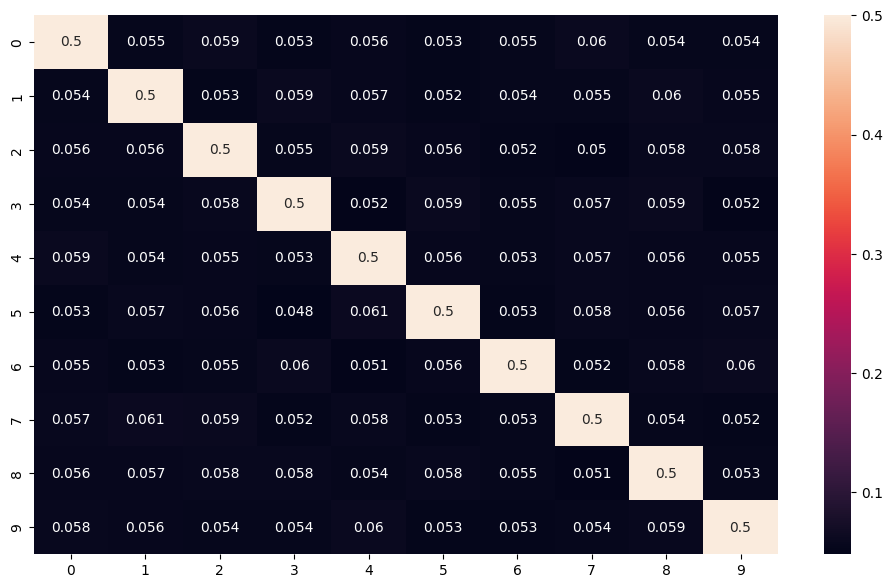

In [ ]:
dataset_name = "Fashion-MNIST"
noisy_train_loader,test_loader, y_sln=sln_data(epsilon=0.5)
train_loader,test_loader, y_true=load_data_custom(dataset_name)
classes = params[dataset_name]["classes"]
# epsilon = 0.5
# y_sln = []
# y_true = []
# for i, data in enumerate(train_loader):
#   _,labels = data 
#   y_true = y_true + labels.tolist()

# for i, data in enumerate(noisy_train_loader):
#   _,labels = data 
#   y_sln = y_sln + labels.tolist()
  

cf_matrix = confusion_matrix(y_true,y_sln)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in range(10)],
                      columns = [i for i in range(10)])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
def d(net,learning_rate, optimizer_name, gamma, train_loader, test_loader):
  # new model
  # net=LeNet5(data=dataset_name)
  
  # training
  max_epoch=10
  criterion=nn.CrossEntropyLoss()

  optimizer = None
  if optimizer_name == "SGD":
    momentum=0.9
    optimizer=optim.SGD(net.parameters(),lr=learning_rate,momentum=momentum)
  elif optimizer_name == "Adam":
    optimizer=optim.Adam(net.parameters(), lr= learning_rate)

  scheduler = None
  if gamma > 0:
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma = gamma)

  train_acc=[]
  test_acc=[]
  for epoch in range(max_epoch):
      if scheduler:
        scheduler.step()
      train_acc_t,test_acc_t=train(train_loader, test_loader, net, criterion, optimizer, epoch)
      train_acc.append(train_acc_t)
      test_acc.append(test_acc_t)

  # display(train_acc,test_acc)
  return net, test_acc

data loaded successfully...
Fashion-MNIST
0.01 0 Adam
iteration # 1
[epoch 1, iter   200] loss: 0.659
[epoch 1, iter   400] loss: 0.451
[epoch 1, iter   600] loss: 0.404
[epoch 1, iter   800] loss: 0.354
epoch 1: train_acc 86.187, test_acc 85.130
[epoch 2, iter   200] loss: 0.331
[epoch 2, iter   400] loss: 0.342
[epoch 2, iter   600] loss: 0.327
[epoch 2, iter   800] loss: 0.320
epoch 2: train_acc 89.533, test_acc 88.440
[epoch 3, iter   200] loss: 0.296
[epoch 3, iter   400] loss: 0.306
[epoch 3, iter   600] loss: 0.287
[epoch 3, iter   800] loss: 0.290
epoch 3: train_acc 89.763, test_acc 88.460
[epoch 4, iter   200] loss: 0.284
[epoch 4, iter   400] loss: 0.272
[epoch 4, iter   600] loss: 0.268
[epoch 4, iter   800] loss: 0.282
epoch 4: train_acc 90.012, test_acc 88.370
[epoch 5, iter   200] loss: 0.259
[epoch 5, iter   400] loss: 0.265
[epoch 5, iter   600] loss: 0.271
[epoch 5, iter   800] loss: 0.260
epoch 5: train_acc 91.205, test_acc 89.500
[epoch 6, iter   200] loss: 0.249
[ep

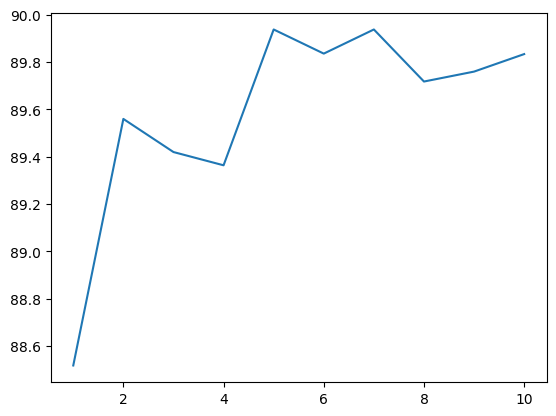

tensor([9, 0, 0,  ..., 3, 0, 5])
data loaded successfully...
Fashion-MNIST
0.01 0 Adam
iteration # 1
[epoch 1, iter   200] loss: 1.429
[epoch 1, iter   400] loss: 1.298
[epoch 1, iter   600] loss: 1.250
[epoch 1, iter   800] loss: 1.238
epoch 1: train_acc 69.428, test_acc 84.960
[epoch 2, iter   200] loss: 1.202
[epoch 2, iter   400] loss: 1.194
[epoch 2, iter   600] loss: 1.199
[epoch 2, iter   800] loss: 1.150
epoch 2: train_acc 70.457, test_acc 86.160
[epoch 3, iter   200] loss: 1.144
[epoch 3, iter   400] loss: 1.143
[epoch 3, iter   600] loss: 1.184
[epoch 3, iter   800] loss: 1.177
epoch 3: train_acc 71.733, test_acc 87.890
[epoch 4, iter   200] loss: 1.147
[epoch 4, iter   400] loss: 1.151
[epoch 4, iter   600] loss: 1.129
[epoch 4, iter   800] loss: 1.159
epoch 4: train_acc 71.940, test_acc 88.090
[epoch 5, iter   200] loss: 1.121
[epoch 5, iter   400] loss: 1.162
[epoch 5, iter   600] loss: 1.136
[epoch 5, iter   800] loss: 1.140
epoch 5: train_acc 72.220, test_acc 87.520
[epo

In [ ]:
dataset_name = "Fashion-MNIST"
optimizer_name = params[dataset_name]["optimizer"]
learning_rate = params[dataset_name]["learning_rates"]
gamma = params[dataset_name]["decay"]
classes = params[dataset_name]["classes"]

epsilons = [0, 0.2, 0.4, 0.6, 0.8]



fig,ax=plt.subplots()
for epsilon in epsilons:
  net = LeNet5(data=dataset_name)
  dataset_name = "Fashion-MNIST"
  
  noisy_train_loader = None
  test_loader = None
  if epsilon == 0:
    noisy_train_loader,test_loader=load_data(dataset_name)
  else:
    noisy_train_loader,test_loader, y_sln=sln_data(epsilon)


  classes = params[dataset_name]["classes"]

  acc_epoch = [0,0,0,0,0,0,0,0,0,0]
  for k in range(5):
    print(dataset_name)
    print(learning_rate, gamma, optimizer_name)
    print("iteration #", k+1)
    net, acc = d(net, learning_rate, optimizer_name, gamma, noisy_train_loader, test_loader)

    for i,x in enumerate(acc):
      acc_epoch[i] += x
    print(acc_epoch)
    
  
  for i,x in enumerate(acc):
      acc_epoch[i] /= 5
  print(acc_epoch)
  print("mean acc_epoch = {} when epsilon = {}%".format(sum(acc_epoch)/ len(acc_epoch) ,  epsilon*100))
  ax.plot(range(1,len(acc_epoch)+1),acc_epoch,label='epsilon={}%'.format(epsilon * 100))
  plt.show()

ax.legend(loc='lower right')
plt.show()

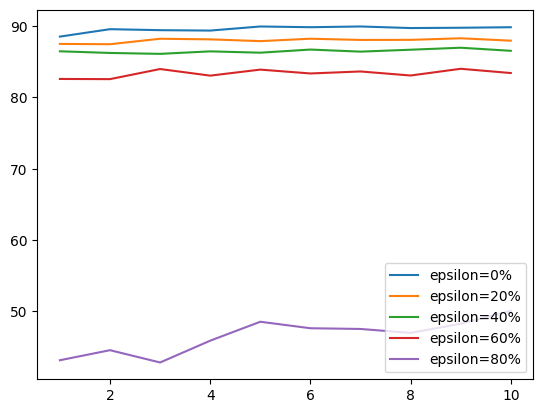

In [ ]:
fig,ax=plt.subplots()
results = []
results.append([88.518, 89.56000000000002, 89.41999999999999, 89.364, 89.938, 89.836, 89.938, 89.71799999999999, 89.76, 89.834]) # epsilon 0%
results.append([87.494, 87.452, 88.218, 88.132, 87.88399999999999, 88.222, 88.05199999999999, 88.064, 88.282, 87.95000000000002]) # epsilon 20%
results.append([86.46000000000001, 86.226, 86.1, 86.45000000000002, 86.26400000000001, 86.70200000000001, 86.412, 86.68000000000002, 86.96000000000001, 86.52799999999999]) # epsilon 40%
results.append([82.582, 82.55800000000002, 83.974, 83.04799999999999, 83.892, 83.352, 83.63199999999999, 83.066, 84.00800000000001, 83.412]) # epsilon 60%
results.append([43.15599999999999, 44.564, 42.842, 45.896, 48.552, 47.64, 47.540000000000006, 46.986000000000004, 48.275999999999996, 50.07]) # epsilon 80%


for i,result in enumerate(results):
  ax.plot(range(1,len(result)+1),result,label='epsilon={}%'.format(i * 20))
ax.legend(loc='lower right')  
plt.show()